In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)

In [2]:
# Loading data
out_of_sample = pd.read_pickle("Datasave/out_of_sample_data.pkl.bz2")
y1_in_sample_filtered = pd.read_pickle('Datasave/Q1_filtered2_0.35.pkl')
y2_in_sample_filtered = pd.read_pickle('Datasave/Q2_filtered2_0.35.pkl')

display(y1_in_sample_filtered.head())

time  sym exch       date         Y1   Q1        X1  \
datetime                                                                       
2022-01-03 09:45:01  09:45:01  SPX  cme 2022-01-03 -49.671906  1.0 -1.985130   
2022-01-03 09:45:02  09:45:02  SPX  cme 2022-01-03 -48.895279  1.0 -0.933646   
2022-01-03 09:45:03  09:45:03  SPX  cme 2022-01-03 -47.067436  1.0 -0.579249   
2022-01-03 09:45:04  09:45:04  SPX  cme 2022-01-03 -47.590408  1.0 -0.658292   
2022-01-03 09:45:05  09:45:05  SPX  cme 2022-01-03 -48.110863  1.0 -1.331419   

                          X10      X100      X101  ...       X90       X91  \
datetime                                           ...                       
2022-01-03 09:45:01 -0.440099  0.044736 -0.010772  ...  0.036888  0.020226   
2022-01-03 09:45:02 -0.380986 -0.854499 -0.951011  ... -0.852265 -0.910145   
2022-01-03 09:45:03 -0.180915 -0.854372 -0.969687  ... -0.842401 -0.919075   
2022-01-03 09:45:04 -0.028344 -0.044026 -0.496256  ... -0.031957 -0.441668   
2022-01-03 09:45:05 -0.100419  0.273158  0.218558  ...  0.281678  0.268776   

                          X92       X93       X94       X95       X96  \
datetime                                                                
2022-01-03 09:45:01 -0.496673 -0.419372 -2.094251 -0.544180  0.947544   
2022-01-03 09:45:02 -0.657351 -0.689837 -2.004462 -1.462824 -0.014917   
2022-01-03 09:45:03 -0.350017 -0.383252 -1.690756 -1.482096 -0.056237   
2022-01-03 09:45:04 -0.085383  0.085024 -1.307463 -0.672521  0.405438   
2022-01-03 09:45:05  0.342332  0.306470 -1.260183 -0.348818  1.124927   

                          X97       X98       X99  
datetime                                           
2022-01-03 09:45:01 -2.114019 -0.783769 -0.229752  
2022-01-03 09:45:02 -2.296994 -1.078146 -0.137521  
2022-01-03 09:45:03 -2.001233 -0.784774  0.171525  
2022-01-03 09:45:04 -1.738940 -0.313380  0.541654  
2022-01-03 09:45:05 -1.298653 -0.081095  0.575009  

[5 rows x 236 columns]

In [3]:
# Function to plot feature distributions
def plot_feature_distributions(data, title_prefix, file_prefix):
    """
    Plots distributions of features that start with 'X' in the given data.
    Args:
    data (DataFrame): The DataFrame containing the data.
    title_prefix (str): Prefix for the plot titles.
    file_prefix (str): Prefix for the filenames where plots are saved.
    """
    # Extract column names starting with 'X' from the DataFrame
    parameters = [col for col in data.columns if col.startswith('X')]

    # Calculate the number of 10x10 plots needed to display all parameters
    num_parameters = len(parameters)
    plots_needed = int(np.ceil(num_parameters / 100.0))
    grid_size = 10

    # Iterate through the number of plots needed
    for plot_index in range(plots_needed):
        # Create a 10x10 grid of subplots
        fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))
        # Set the title for each set of plots
        fig.suptitle(f'{title_prefix} Distribution of Features {plot_index + 1}', fontsize=16)

        # Flatten the array of axes for easier iteration
        axs = axs.flatten()

        # Iterate through each subplot in the current grid
        for i, ax in enumerate(axs):
            param_index = plot_index * 100 + i
            if param_index < num_parameters:
                # Get the current parameter to plot
                parameter = parameters[param_index]
                # Plot the histogram of the parameter
                sns.histplot(data[parameter], kde=False, ax=ax, bins=30, color='blue')
                
                # Calculate mean and standard deviation for the parameter
                mean = data[parameter].mean()
                std = data[parameter].std()
                # Display mean and standard deviation on the subplot
                ax.text(0.05, 0.95, f'$\mu={mean:.2f}$\n$\sigma={std:.2f}$', transform=ax.transAxes, fontsize=9, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
                # Set the title for each subplot
                ax.set_title(parameter, fontsize=8)
            else:
                # Hide unused subplots
                ax.axis('off')

        # Adjust layout to accommodate the main title
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        # Save the figure to a file
        plt.savefig(f'Plot n result save/{file_prefix}_distributions_{plot_index + 1}.png')
        # Close the figure to free up memory
        plt.close(fig)

    logging.info(f"All plots for {title_prefix} were saved successfully.")

# Plotting feature distributions
plot_feature_distributions(y1_in_sample_filtered, 'In Sample - Y1', 'y1_in_sample')
plot_feature_distributions(y2_in_sample_filtered, 'In Sample - Y2', 'y2_in_sample')


INFO:root:All plots for In Sample - Y1 were saved successfully.
INFO:root:All plots for In Sample - Y2 were saved successfully.


In [4]:
# # Function to summarize data in chunks

def summarize_in_chunks(data, chunk_size=100000):
    """
    Summarizes data in chunks, calculating mean descriptive statistics for numerical columns.
    Args:
    data (DataFrame): The DataFrame containing the data.
    chunk_size (int): The size of each chunk to process.
    Returns:
    DataFrame: DataFrame containing summarized statistics.
    """
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    stats = {col: [] for col in numeric_cols}

    # Iterate over data in chunks
    for start in range(0, len(data), chunk_size):
        chunk = data.iloc[start:start + chunk_size]
        desc_stats = chunk.describe()

        # Collect stats for each chunk
        for col in numeric_cols:
            stats[col].append(desc_stats[col])

    # Aggregate stats across chunks
    aggregated_stats = {col: pd.concat(stats[col], axis=1).mean(axis=1) for col in numeric_cols}
    return pd.DataFrame(aggregated_stats)


# Use the function to summarize the data
summary_statistics_y1 = summarize_in_chunks(y1_in_sample_filtered)
summary_statistics_y2 = summarize_in_chunks(y2_in_sample_filtered)

# Display the summary statistics
display(summary_statistics_y1)
display(summary_statistics_y2)

Y1            Q1            X1           X10          X100  \
count  99285.714286  99285.714286  92674.650794  92672.587302  92677.206349   
mean       0.013385      0.967569      0.033106      0.011937      0.000645   
min      -63.845621      0.118413     -3.257983     -2.989199     -3.517171   
25%       -6.753186      1.000000     -0.408781     -0.336155     -0.327115   
50%        0.039480      1.000000      0.035307      0.011174     -0.003516   
75%        6.776964      1.000000      0.476439      0.362015      0.323924   
max       66.741314      1.000000      3.155172      2.885187      3.836226   
std       11.863403      0.147828      0.666857      0.625719      0.503084   

               X101          X102          X103          X104          X105  \
count  92676.650794  92677.206349  92675.126984  92675.206349  92677.206349   
mean       0.000308      0.000819      0.000504      0.004781      0.005749   
min       -3.075744     -4.061652     -2.862757     -2.632656     -3.820328   
25%       -0.299237     -0.298418     -0.276954     -0.279641     -0.407462   
50%       -0.004016     -0.001026     -0.001228      0.002419      0.000123   
75%        0.295594      0.297422      0.274747      0.286224      0.413758   
max        3.284600      3.920869      2.852685      2.797962      4.225808   
std        0.458622      0.447191      0.412607      0.427316      0.624184   

       ...           X90           X91           X92           X93  \
count  ...  92677.206349  92676.650794  92677.206349  92675.126984   
mean   ...      0.000442      0.000185      0.000539      0.000330   
min    ...     -3.450128     -3.013868     -4.015074     -2.825142   
25%    ...     -0.308687     -0.283595     -0.284780     -0.262786   
50%    ...     -0.003326     -0.003720     -0.001121     -0.001313   
75%    ...      0.305565      0.280049      0.283608      0.260724   
max    ...      3.746070      3.214263      3.855248      2.780882   
std    ...      0.477304      0.437175      0.428584      0.394407   

                X94           X95           X96           X97           X98  \
count  92675.206349  92677.206349  92676.650794  92677.206349  92675.126984   
mean       0.042509      0.029980      0.044872      0.049074      0.038781   
min       -3.178270     -4.163264     -4.260850     -4.561441     -3.638031   
25%       -0.292334     -0.453408     -0.404713     -0.365965     -0.357322   
50%        0.030074      0.025535      0.031183      0.042268      0.031014   
75%        0.359189      0.509981      0.476551      0.454177      0.422046   
max        3.561467      4.652333      4.694657      4.699495      3.740372   
std        0.554983      0.753893      0.761015      0.651363      0.633025   

                X99  
count  92675.206349  
mean       0.000312  
min       -2.443171  
25%       -0.236783  
50%       -0.000868  
75%        0.236081  
max        2.597649  
std        0.363650  

[8 rows x 232 columns]

Y2            Q2            X1           X10          X100  \
count  99285.714286  99285.714286  92674.650794  92672.587302  92677.206349   
mean       0.001911      0.964441      0.033106      0.011937      0.000645   
min      -83.160108      0.106825     -3.257983     -2.989199     -3.517171   
25%       -8.842117      0.987460     -0.408781     -0.336155     -0.327115   
50%        0.057364      1.000000      0.035307      0.011174     -0.003516   
75%        8.795812      1.000000      0.476439      0.362015      0.323924   
max       89.060870      1.000000      3.155172      2.885187      3.836226   
std       15.677158      0.158938      0.666857      0.625719      0.503084   

               X101          X102          X103          X104          X105  \
count  92676.650794  92677.206349  92675.126984  92675.206349  92677.206349   
mean       0.000308      0.000819      0.000504      0.004781      0.005749   
min       -3.075744     -4.061652     -2.862757     -2.632656     -3.820328   
25%       -0.299237     -0.298418     -0.276954     -0.279641     -0.407462   
50%       -0.004016     -0.001026     -0.001228      0.002419      0.000123   
75%        0.295594      0.297422      0.274747      0.286224      0.413758   
max        3.284600      3.920869      2.852685      2.797962      4.225808   
std        0.458622      0.447191      0.412607      0.427316      0.624184   

       ...           X90           X91           X92           X93  \
count  ...  92677.206349  92676.650794  92677.206349  92675.126984   
mean   ...      0.000442      0.000185      0.000539      0.000330   
min    ...     -3.450128     -3.013868     -4.015074     -2.825142   
25%    ...     -0.308687     -0.283595     -0.284780     -0.262786   
50%    ...     -0.003326     -0.003720     -0.001121     -0.001313   
75%    ...      0.305565      0.280049      0.283608      0.260724   
max    ...      3.746070      3.214263      3.855248      2.780882   
std    ...      0.477304      0.437175      0.428584      0.394407   

                X94           X95           X96           X97           X98  \
count  92675.206349  92677.206349  92676.650794  92677.206349  92675.126984   
mean       0.042509      0.029980      0.044872      0.049074      0.038781   
min       -3.178270     -4.163264     -4.260850     -4.561441     -3.638031   
25%       -0.292334     -0.453408     -0.404713     -0.365965     -0.357322   
50%        0.030074      0.025535      0.031183      0.042268      0.031014   
75%        0.359189      0.509981      0.476551      0.454177      0.422046   
max        3.561467      4.652333      4.694657      4.699495      3.740372   
std        0.554983      0.753893      0.761015      0.651363      0.633025   

                X99  
count  92675.206349  
mean       0.000312  
min       -2.443171  
25%       -0.236783  
50%       -0.000868  
75%        0.236081  
max        2.597649  
std        0.363650  

[8 rows x 232 columns]

In [5]:
# Function for linear regression analysis
def linear_regression_analysis(data, dependent_var):
    """
    Performs linear regression analysis on the given data.
    Args:
    data (DataFrame): The DataFrame containing the data.
    dependent_var (str): The name of the dependent variable.
    Returns:
    DataFrame: DataFrame containing regression results.
    """
    results = {}
    for col in data.columns:
        if col.startswith('X'):  # Assuming your independent variables start with 'X'
            # Drop NA values for the specific 'X' column and the dependent variable
            clean_data = data[[col, dependent_var]].dropna()
            x = clean_data[col].values
            y = clean_data[dependent_var].values

            # Check if all x values are identical
            if len(set(x)) > 1:
                # Perform linear regression
                slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
                t_stat = slope / std_err if std_err != 0 else float('inf')
                results[col] = {
                    'slope': slope,
                    'intercept': intercept,
                    'r_value': r_value,
                    'p_value': p_value,
                    'std_err': std_err,
                    't_stat': t_stat  # Add t-statistic to the results
                }
            else:
                # Handle the case where all x values are identical
                results[col] = {
                    'slope': None,
                    'intercept': None,
                    'r_value': None,
                    'p_value': None,
                    'std_err': None,
                    't_stat': None
                }

    return pd.DataFrame(results).T



# Perform linear regression analysis for Y1 and Y2
regression_results_Y1 = linear_regression_analysis(y1_in_sample_filtered, 'Y1')
regression_results_Y2 = linear_regression_analysis(y2_in_sample_filtered, 'Y2')

# Display the DataFrames
display(regression_results_Y1)
display(regression_results_Y2)

slope  intercept   r_value       p_value   std_err     t_stat
X1    0.140951   0.015235  0.008345  1.995182e-90  0.006990  20.165160
X10   0.023964   0.019381  0.001312  1.522908e-03  0.007559   3.170284
X100  0.013206   0.019732  0.000567  1.707269e-01  0.009640   1.369872
X101  0.033954   0.019752  0.001331  1.294750e-03  0.010554   3.217143
X102 -0.124447   0.019847 -0.004715  4.568436e-30  0.010924 -11.392350
...        ...        ...       ...           ...       ...        ...
X95  -0.033894   0.020746 -0.002186  1.274733e-07  0.006416  -5.282448
X96   0.002324   0.019660  0.000152  7.129024e-01  0.006315   0.367961
X97  -0.023198   0.020900 -0.001287  1.876370e-03  0.007461  -3.109135
X98   0.012342   0.019222  0.000666  1.077002e-01  0.007672   1.608617
X99   0.011126   0.019687  0.000343  4.073593e-01  0.013429   0.828550

[230 rows x 6 columns]

slope  intercept   r_value        p_value   std_err     t_stat
X1    0.443449  -0.001692  0.019956   0.000000e+00  0.009195  48.229463
X10   0.189197   0.010031  0.007874   1.059573e-80  0.009945  19.025261
X100 -0.135312   0.012543 -0.004415   1.429029e-26  0.012683 -10.668560
X101 -0.093265   0.012507 -0.002780   1.857145e-11  0.013885  -6.716848
X102  0.031733   0.012429  0.000914   2.724416e-02  0.014372   2.208002
...        ...        ...       ...            ...       ...        ...
X95  -0.308718   0.021609 -0.015135  7.550037e-293  0.008441 -36.575585
X96  -0.194243   0.021079 -0.009676  6.716580e-121  0.008308 -23.381254
X97   0.052725   0.009821  0.002223   7.823748e-08  0.009816   5.371154
X98   0.027181   0.011354  0.001114   7.086633e-03  0.010094   2.692746
X99   0.033302   0.012364  0.000780   5.943401e-02  0.017667   1.884969

[230 rows x 6 columns]

In [6]:
# Replace None with 0 in 't_stat' column
regression_results_Y1['t_stat'] = regression_results_Y1['t_stat'].fillna(0)
regression_results_Y2['t_stat'] = regression_results_Y2['t_stat'].fillna(0)

# Now apply your filtering criteria
significant_vars_Y1 = regression_results_Y1.loc[
    (regression_results_Y1['p_value'] < 0.05) & 
    (abs(regression_results_Y1['t_stat']) > 2)
]

significant_vars_Y2 = regression_results_Y2.loc[
    (regression_results_Y2['p_value'] < 0.05) & 
    (abs(regression_results_Y2['t_stat']) > 2)
]

# Display the filtered DataFrames
display(significant_vars_Y1)
display(significant_vars_Y2)


slope  intercept   r_value       p_value   std_err     t_stat
X1    0.140951   0.015235  0.008345  1.995182e-90  0.006990  20.165160
X10   0.023964   0.019381  0.001312  1.522908e-03  0.007559   3.170284
X101  0.033954   0.019752  0.001331  1.294750e-03  0.010554   3.217143
X102 -0.124447   0.019847 -0.004715  4.568436e-30  0.010924 -11.392350
X103 -0.026344   0.019711 -0.000924  2.551917e-02  0.011795  -2.233452
...        ...        ...       ...           ...       ...        ...
X91   0.040607   0.019755  0.001519  2.418480e-04  0.011062   3.670744
X92  -0.131113   0.019815 -0.004764  1.169687e-30  0.011391 -11.510441
X94  -0.059213   0.022156 -0.002812  1.084664e-11  0.008714  -6.794809
X95  -0.033894   0.020746 -0.002186  1.274733e-07  0.006416  -5.282448
X97  -0.023198   0.020900 -0.001287  1.876370e-03  0.007461  -3.109135

[175 rows x 6 columns]

slope  intercept   r_value        p_value   std_err     t_stat
X1    0.443449  -0.001692  0.019956   0.000000e+00  0.009195  48.229463
X10   0.189197   0.010031  0.007874   1.059573e-80  0.009945  19.025261
X100 -0.135312   0.012543 -0.004415   1.429029e-26  0.012683 -10.668560
X101 -0.093265   0.012507 -0.002780   1.857145e-11  0.013885  -6.716848
X102  0.031733   0.012429  0.000914   2.724416e-02  0.014372   2.208002
...        ...        ...       ...            ...       ...        ...
X94  -0.145265   0.018424 -0.005244   8.630886e-37  0.011465 -12.670455
X95  -0.308718   0.021609 -0.015135  7.550037e-293  0.008441 -36.575585
X96  -0.194243   0.021079 -0.009676  6.716580e-121  0.008308 -23.381254
X97   0.052725   0.009821  0.002223   7.823748e-08  0.009816   5.371154
X98   0.027181   0.011354  0.001114   7.086633e-03  0.010094   2.692746

[187 rows x 6 columns]

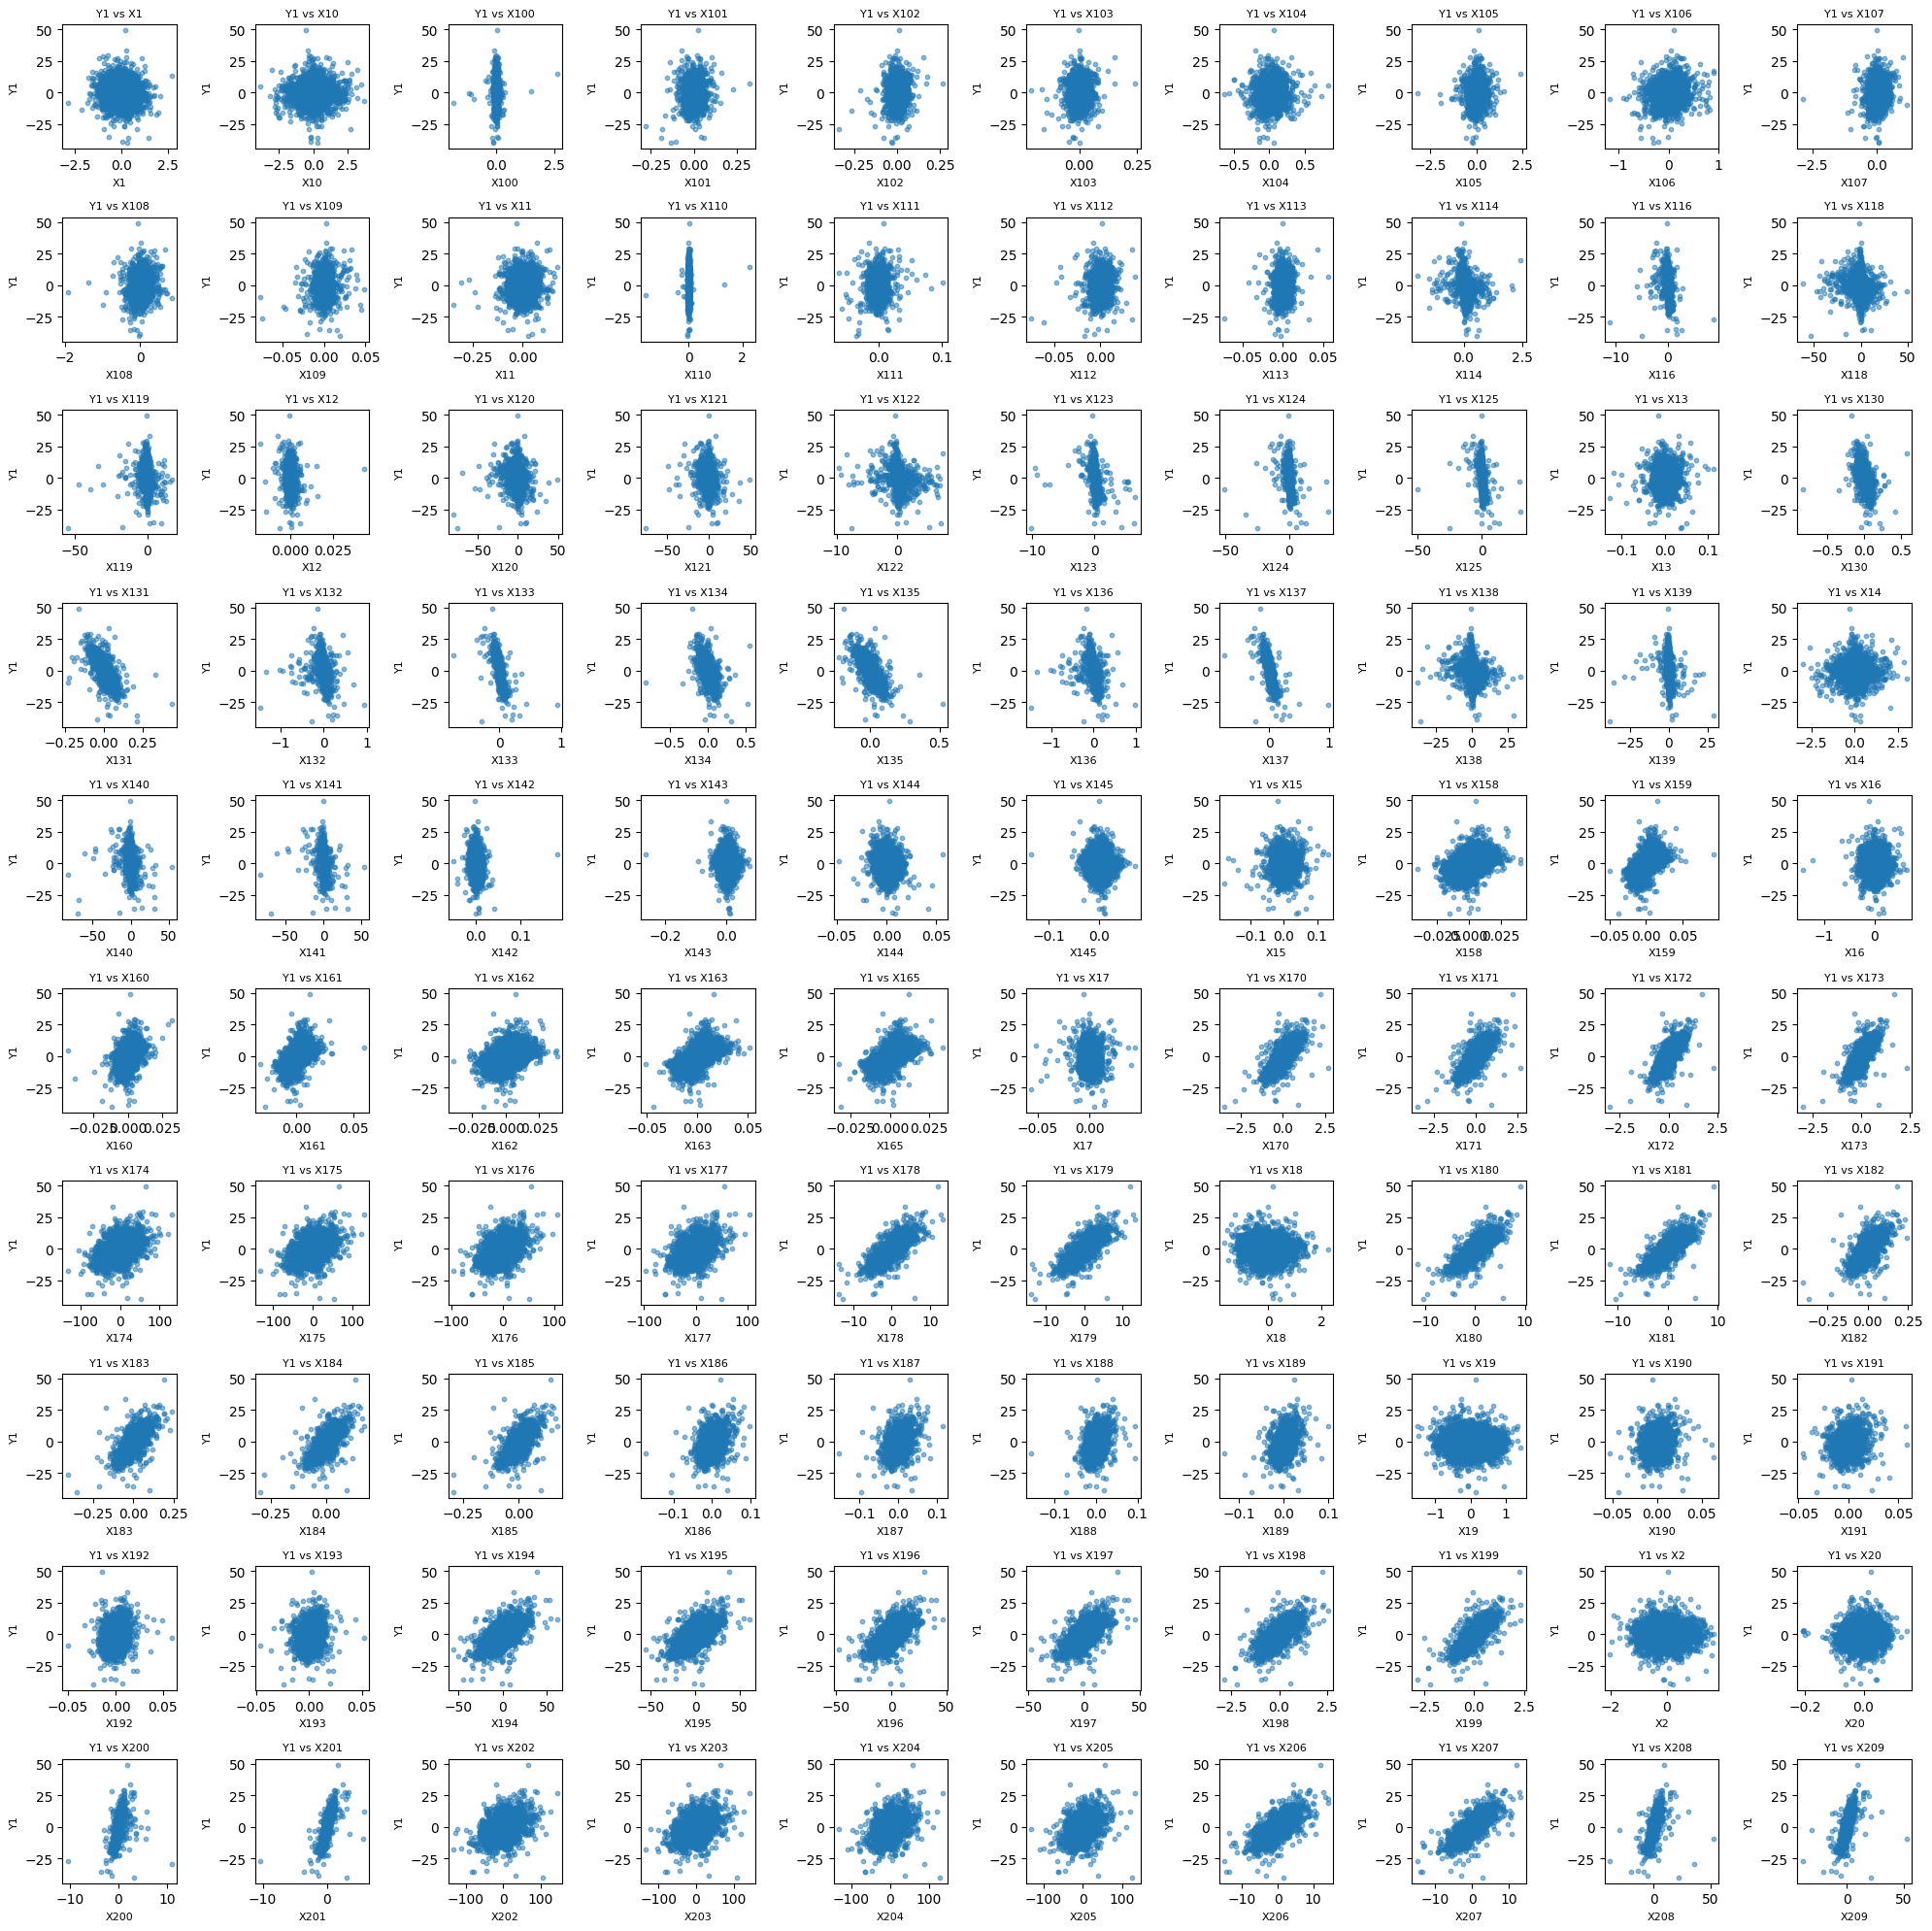

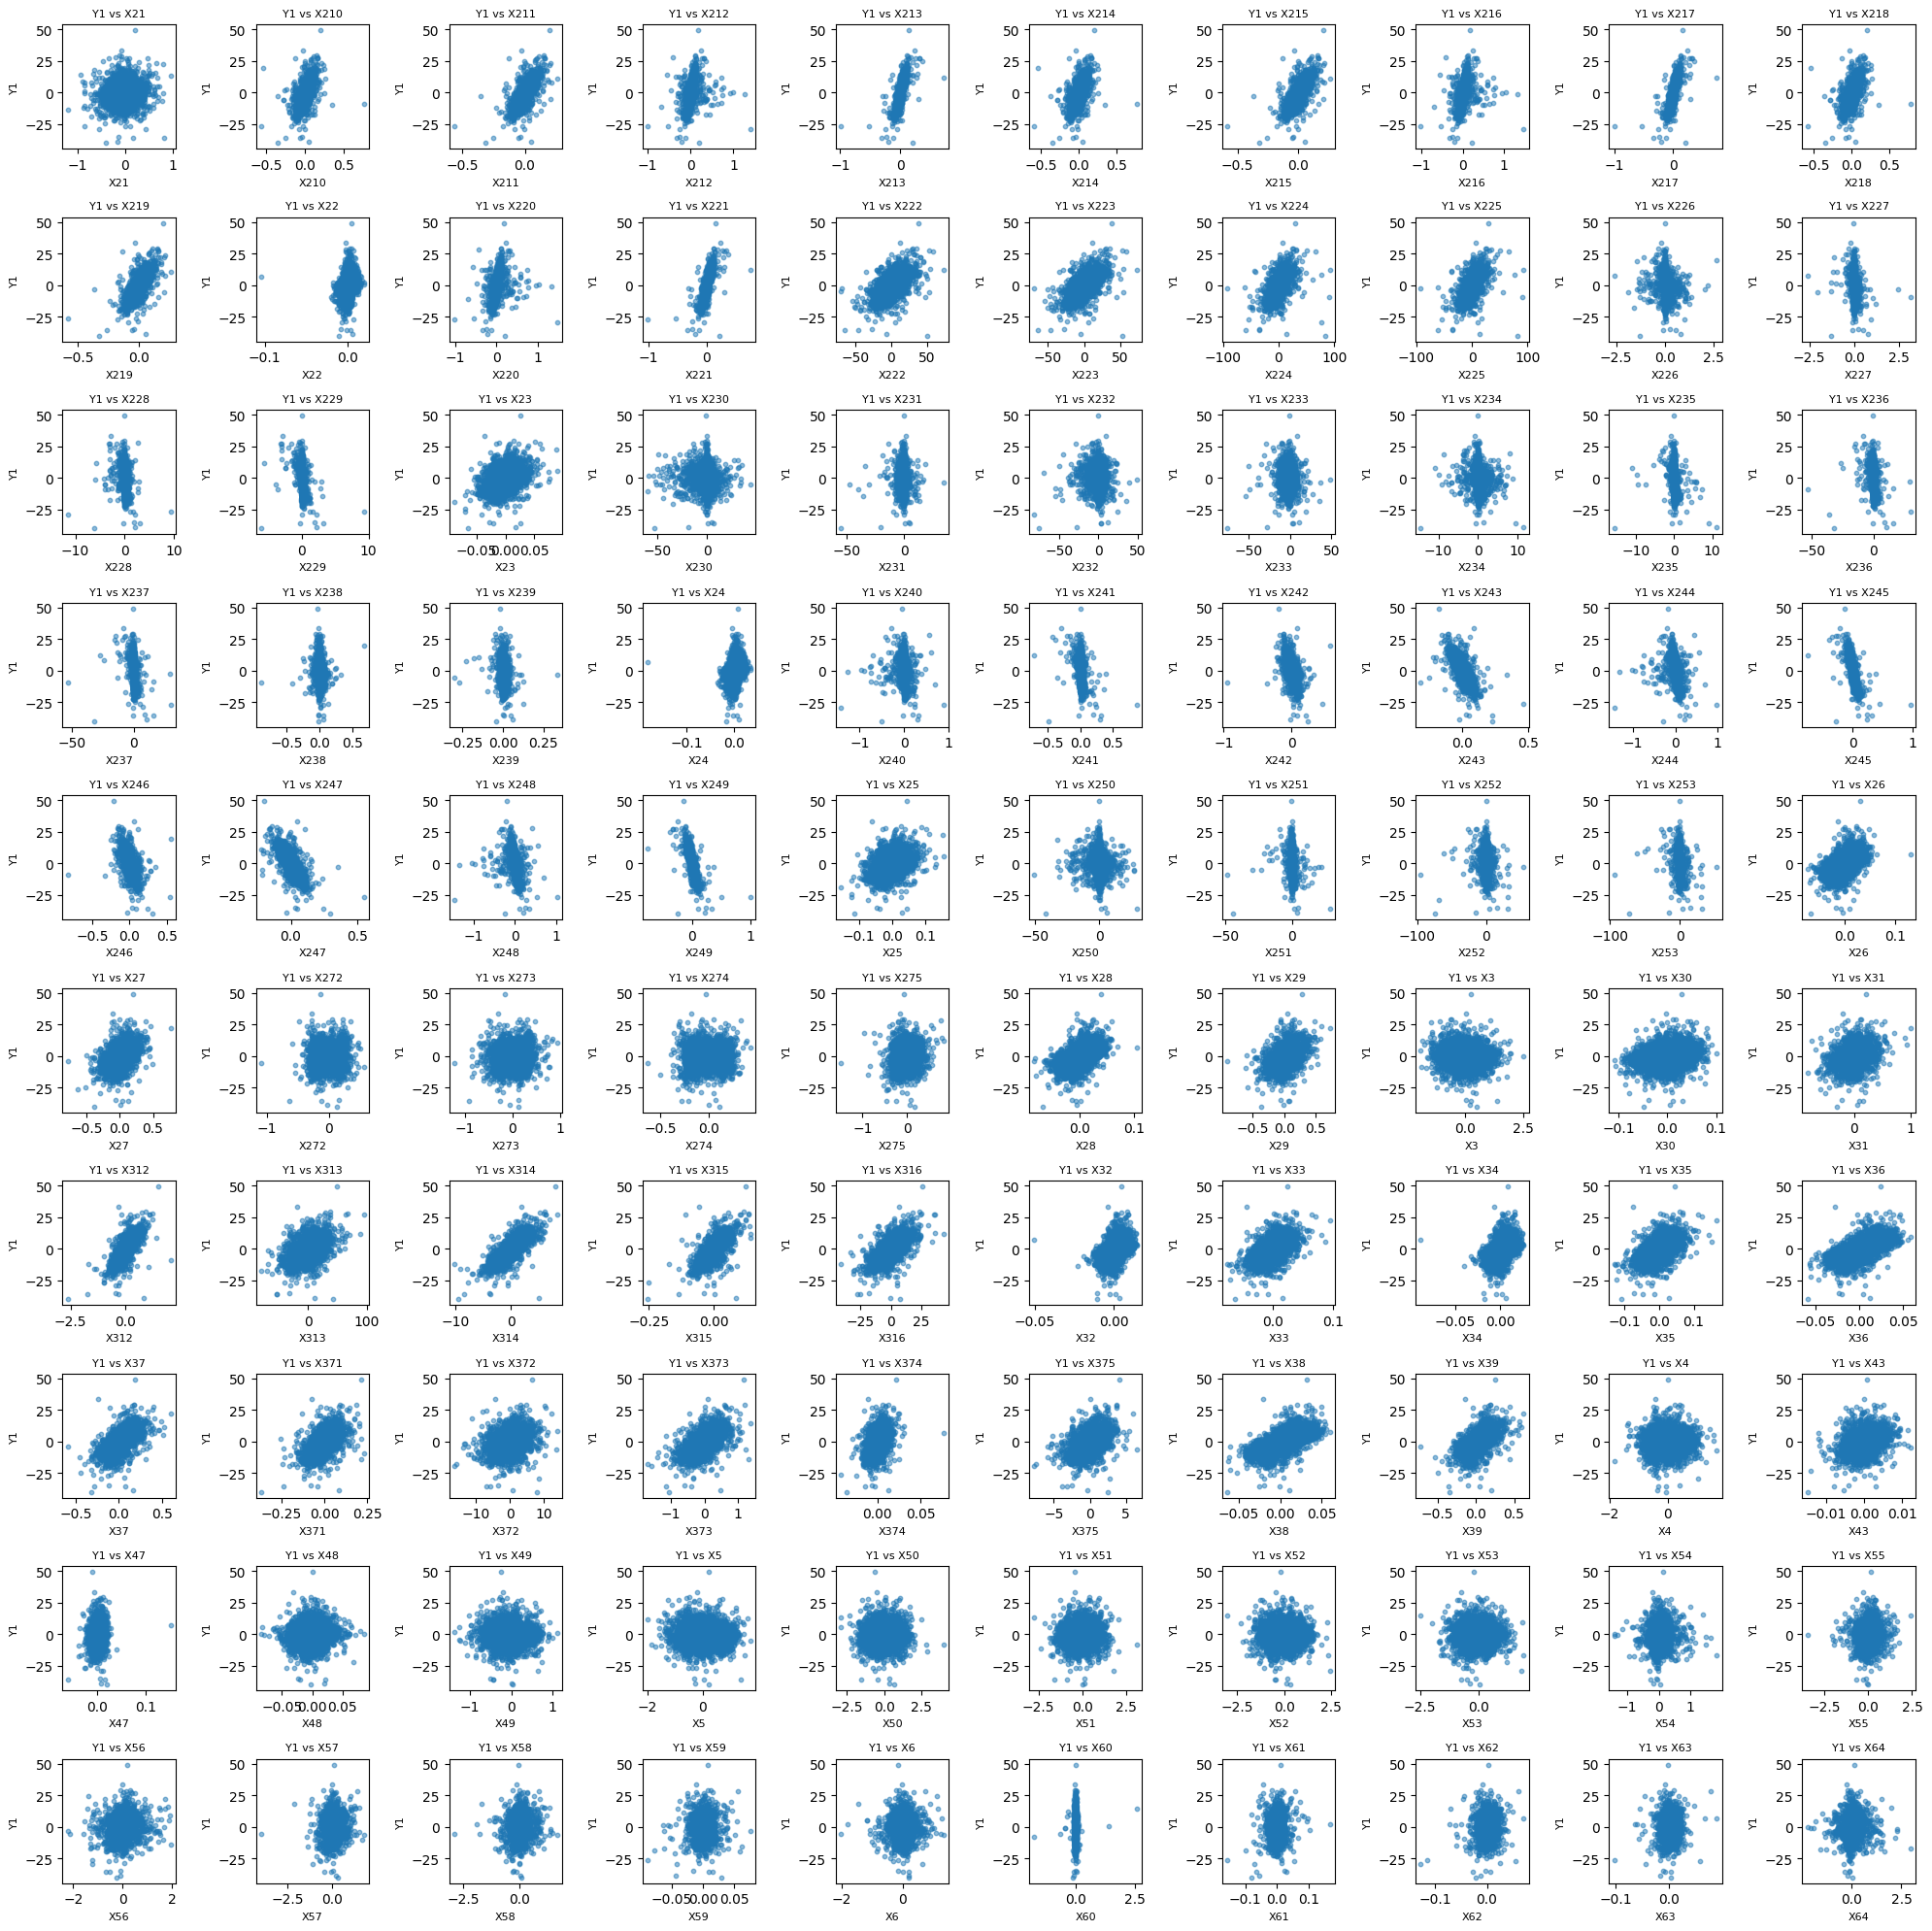

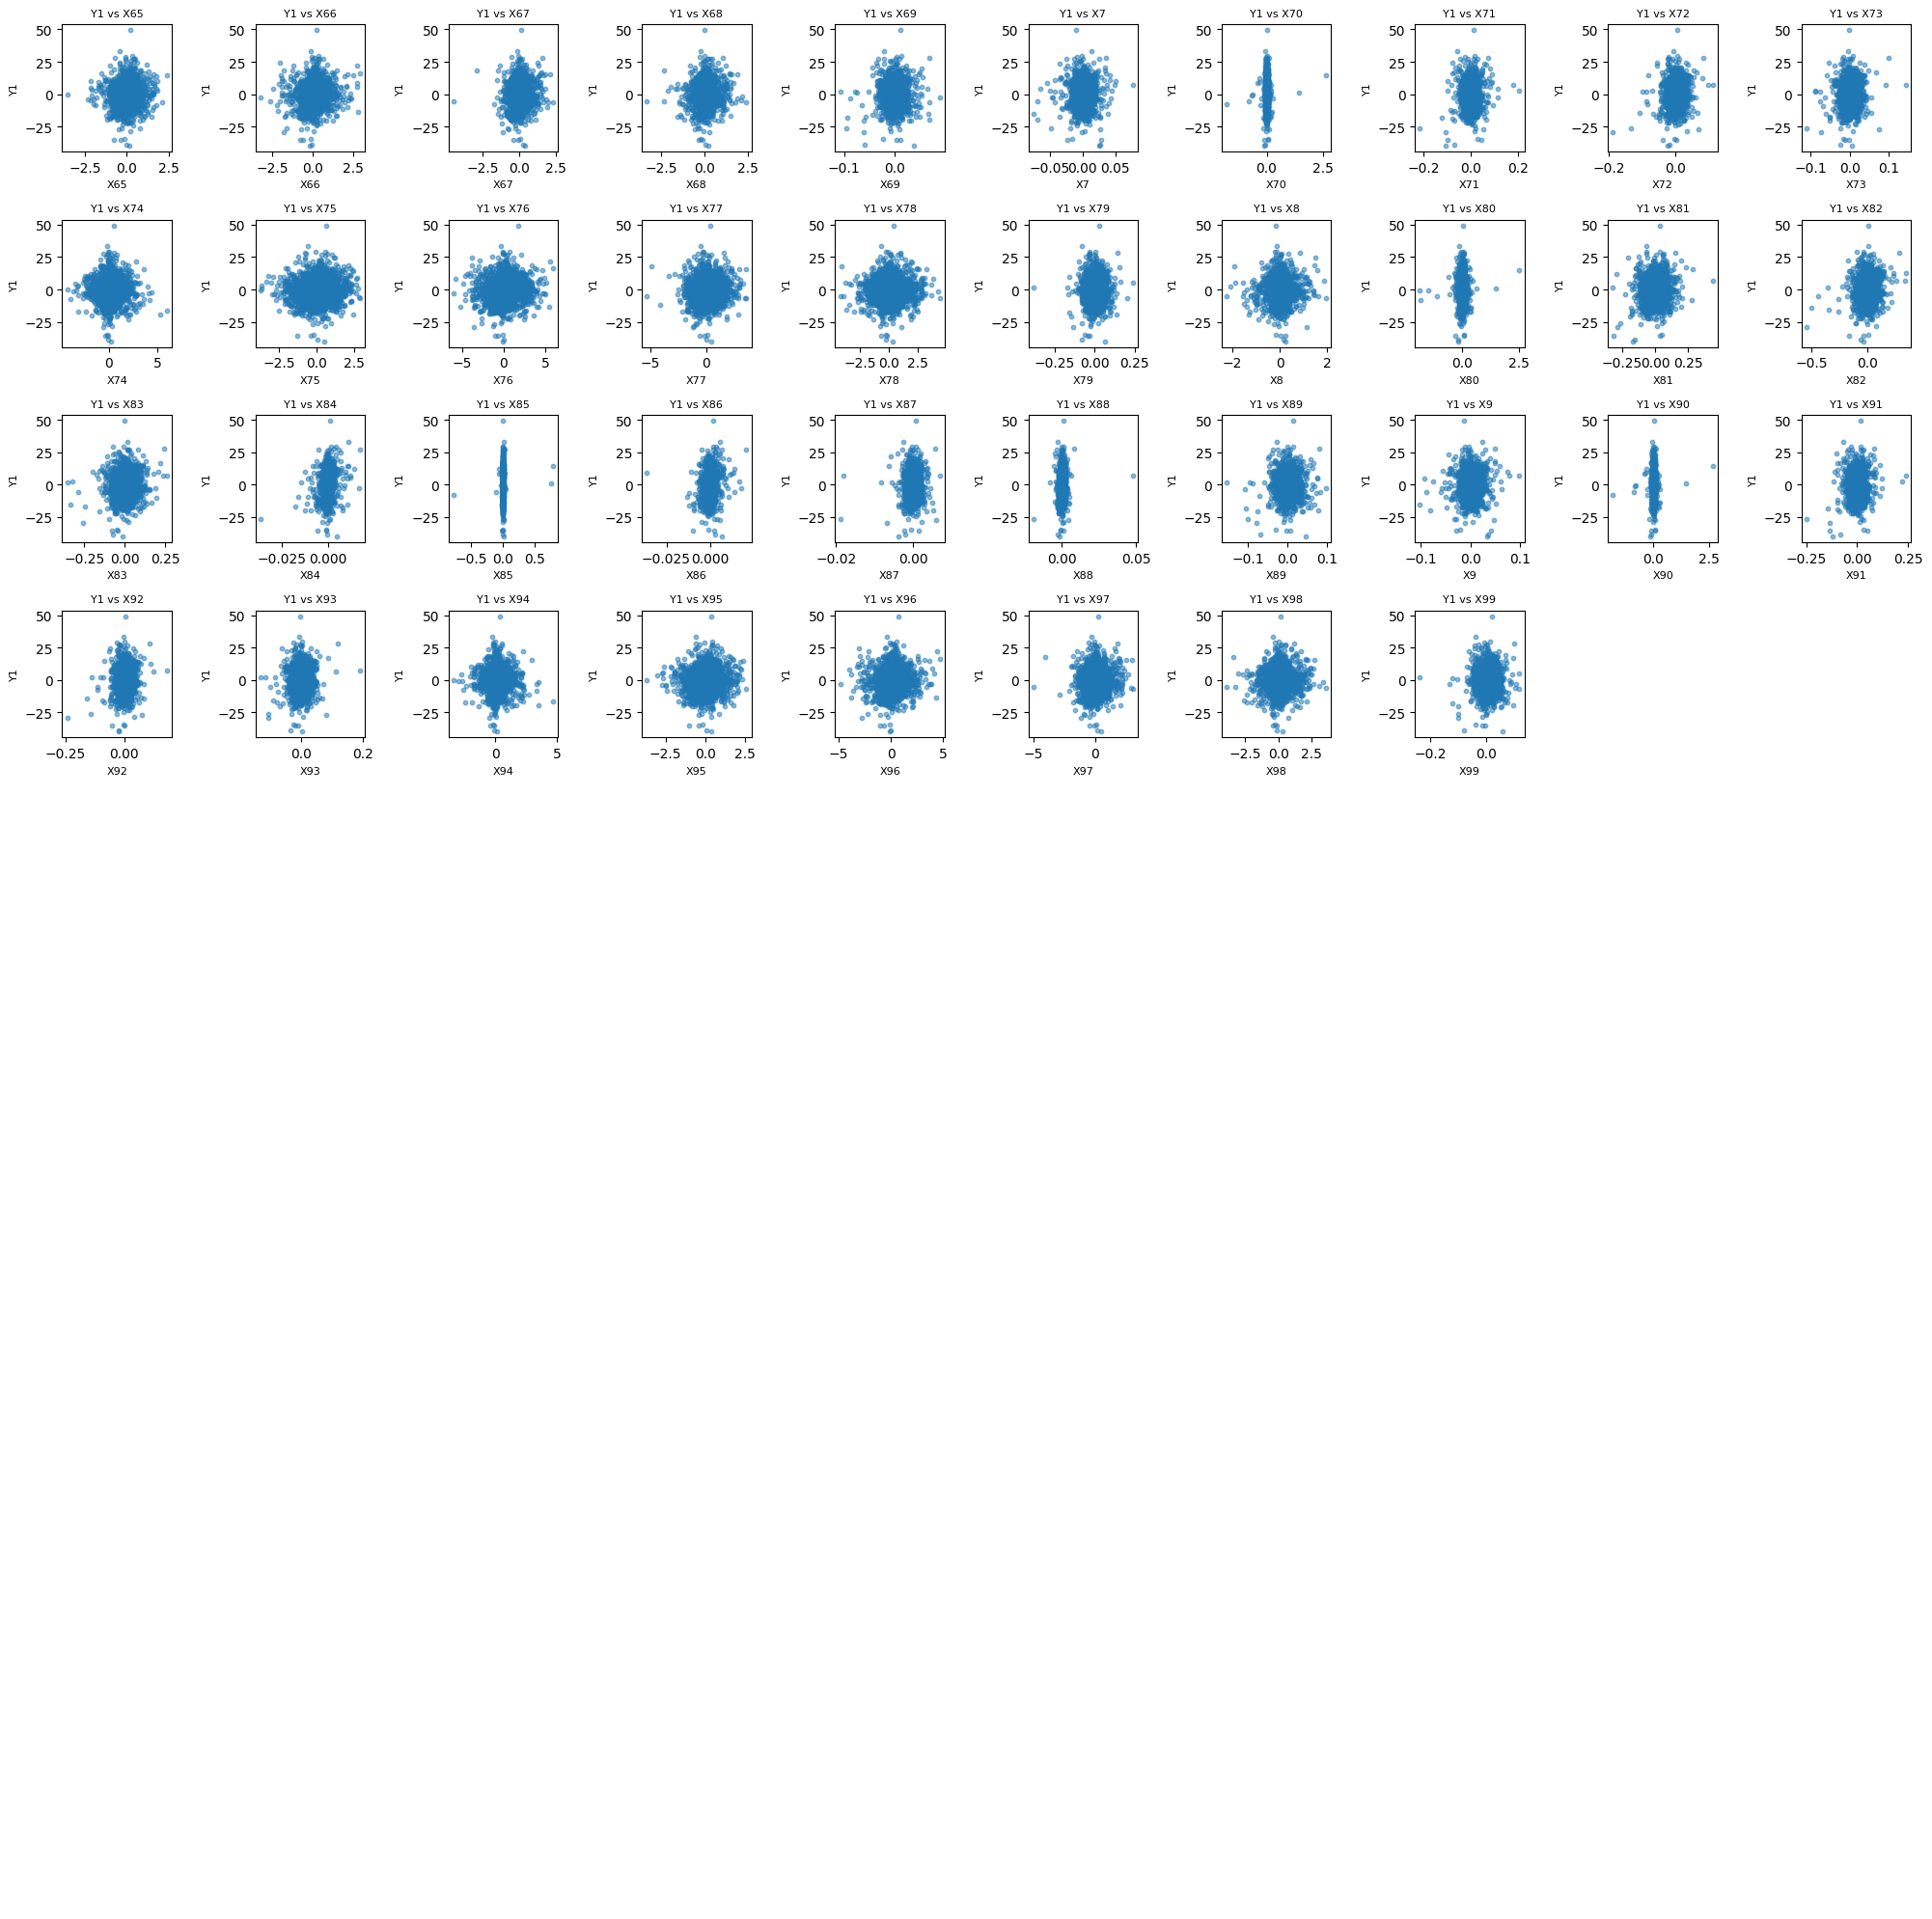

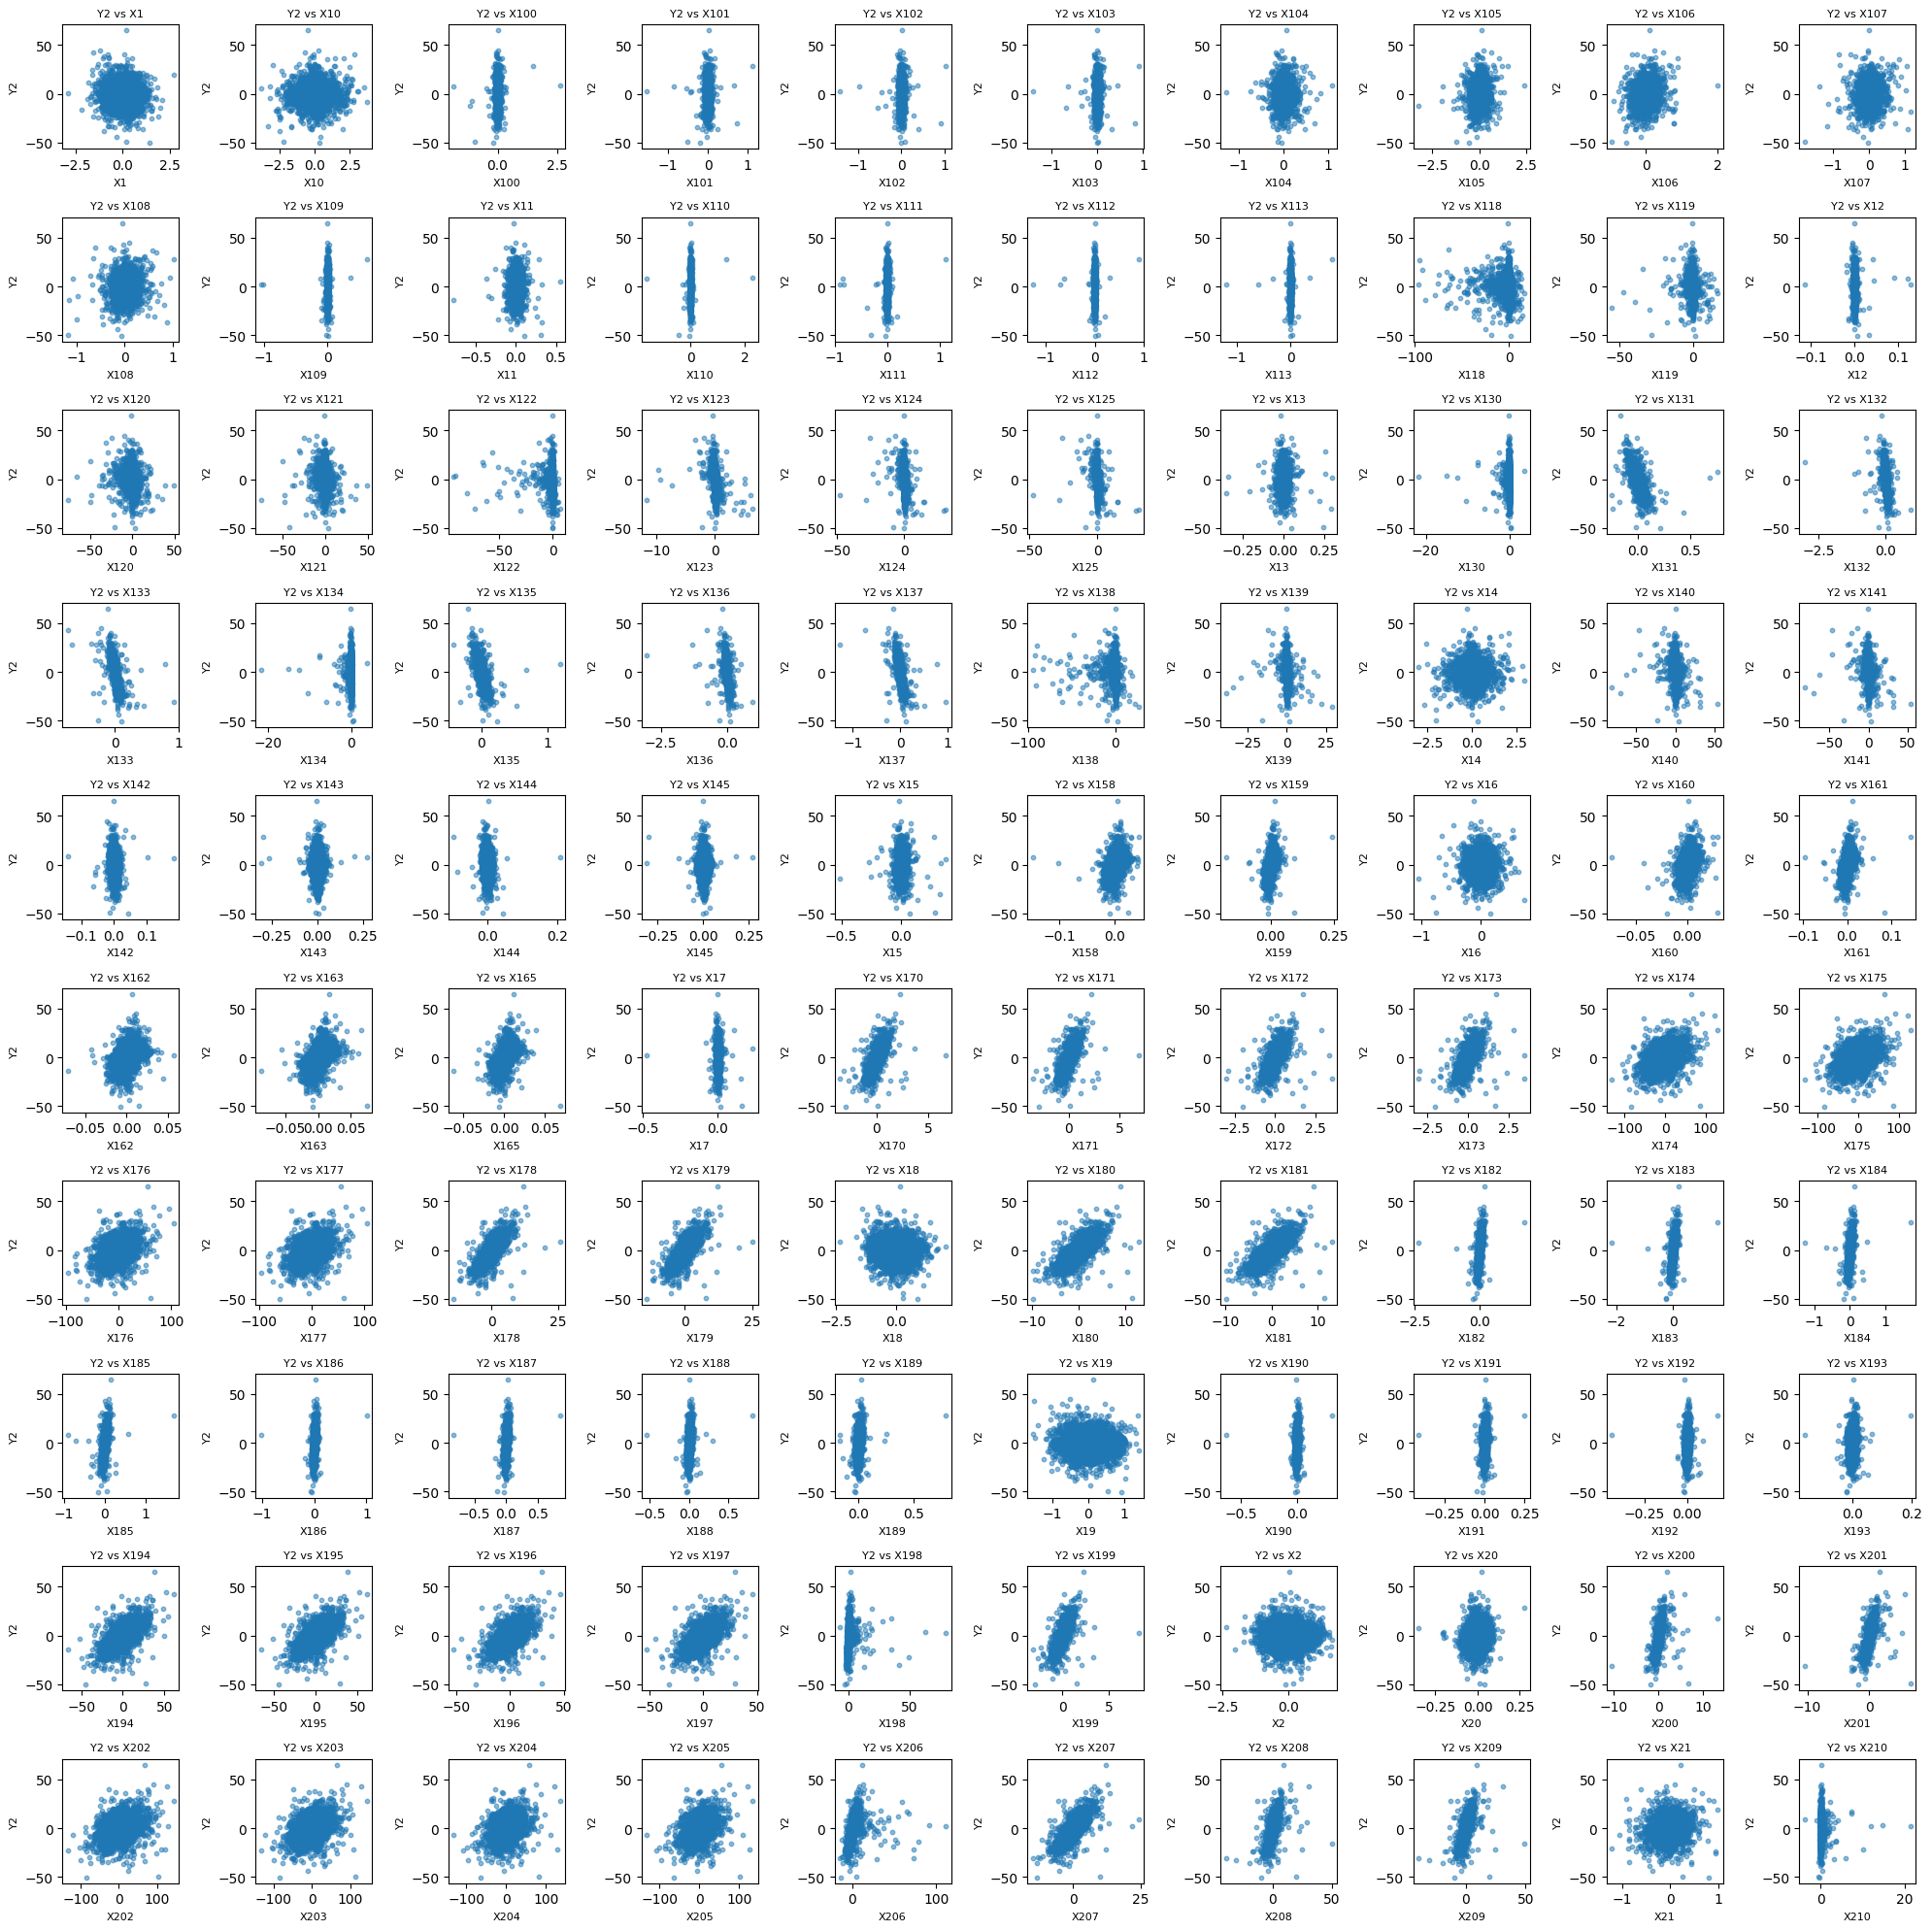

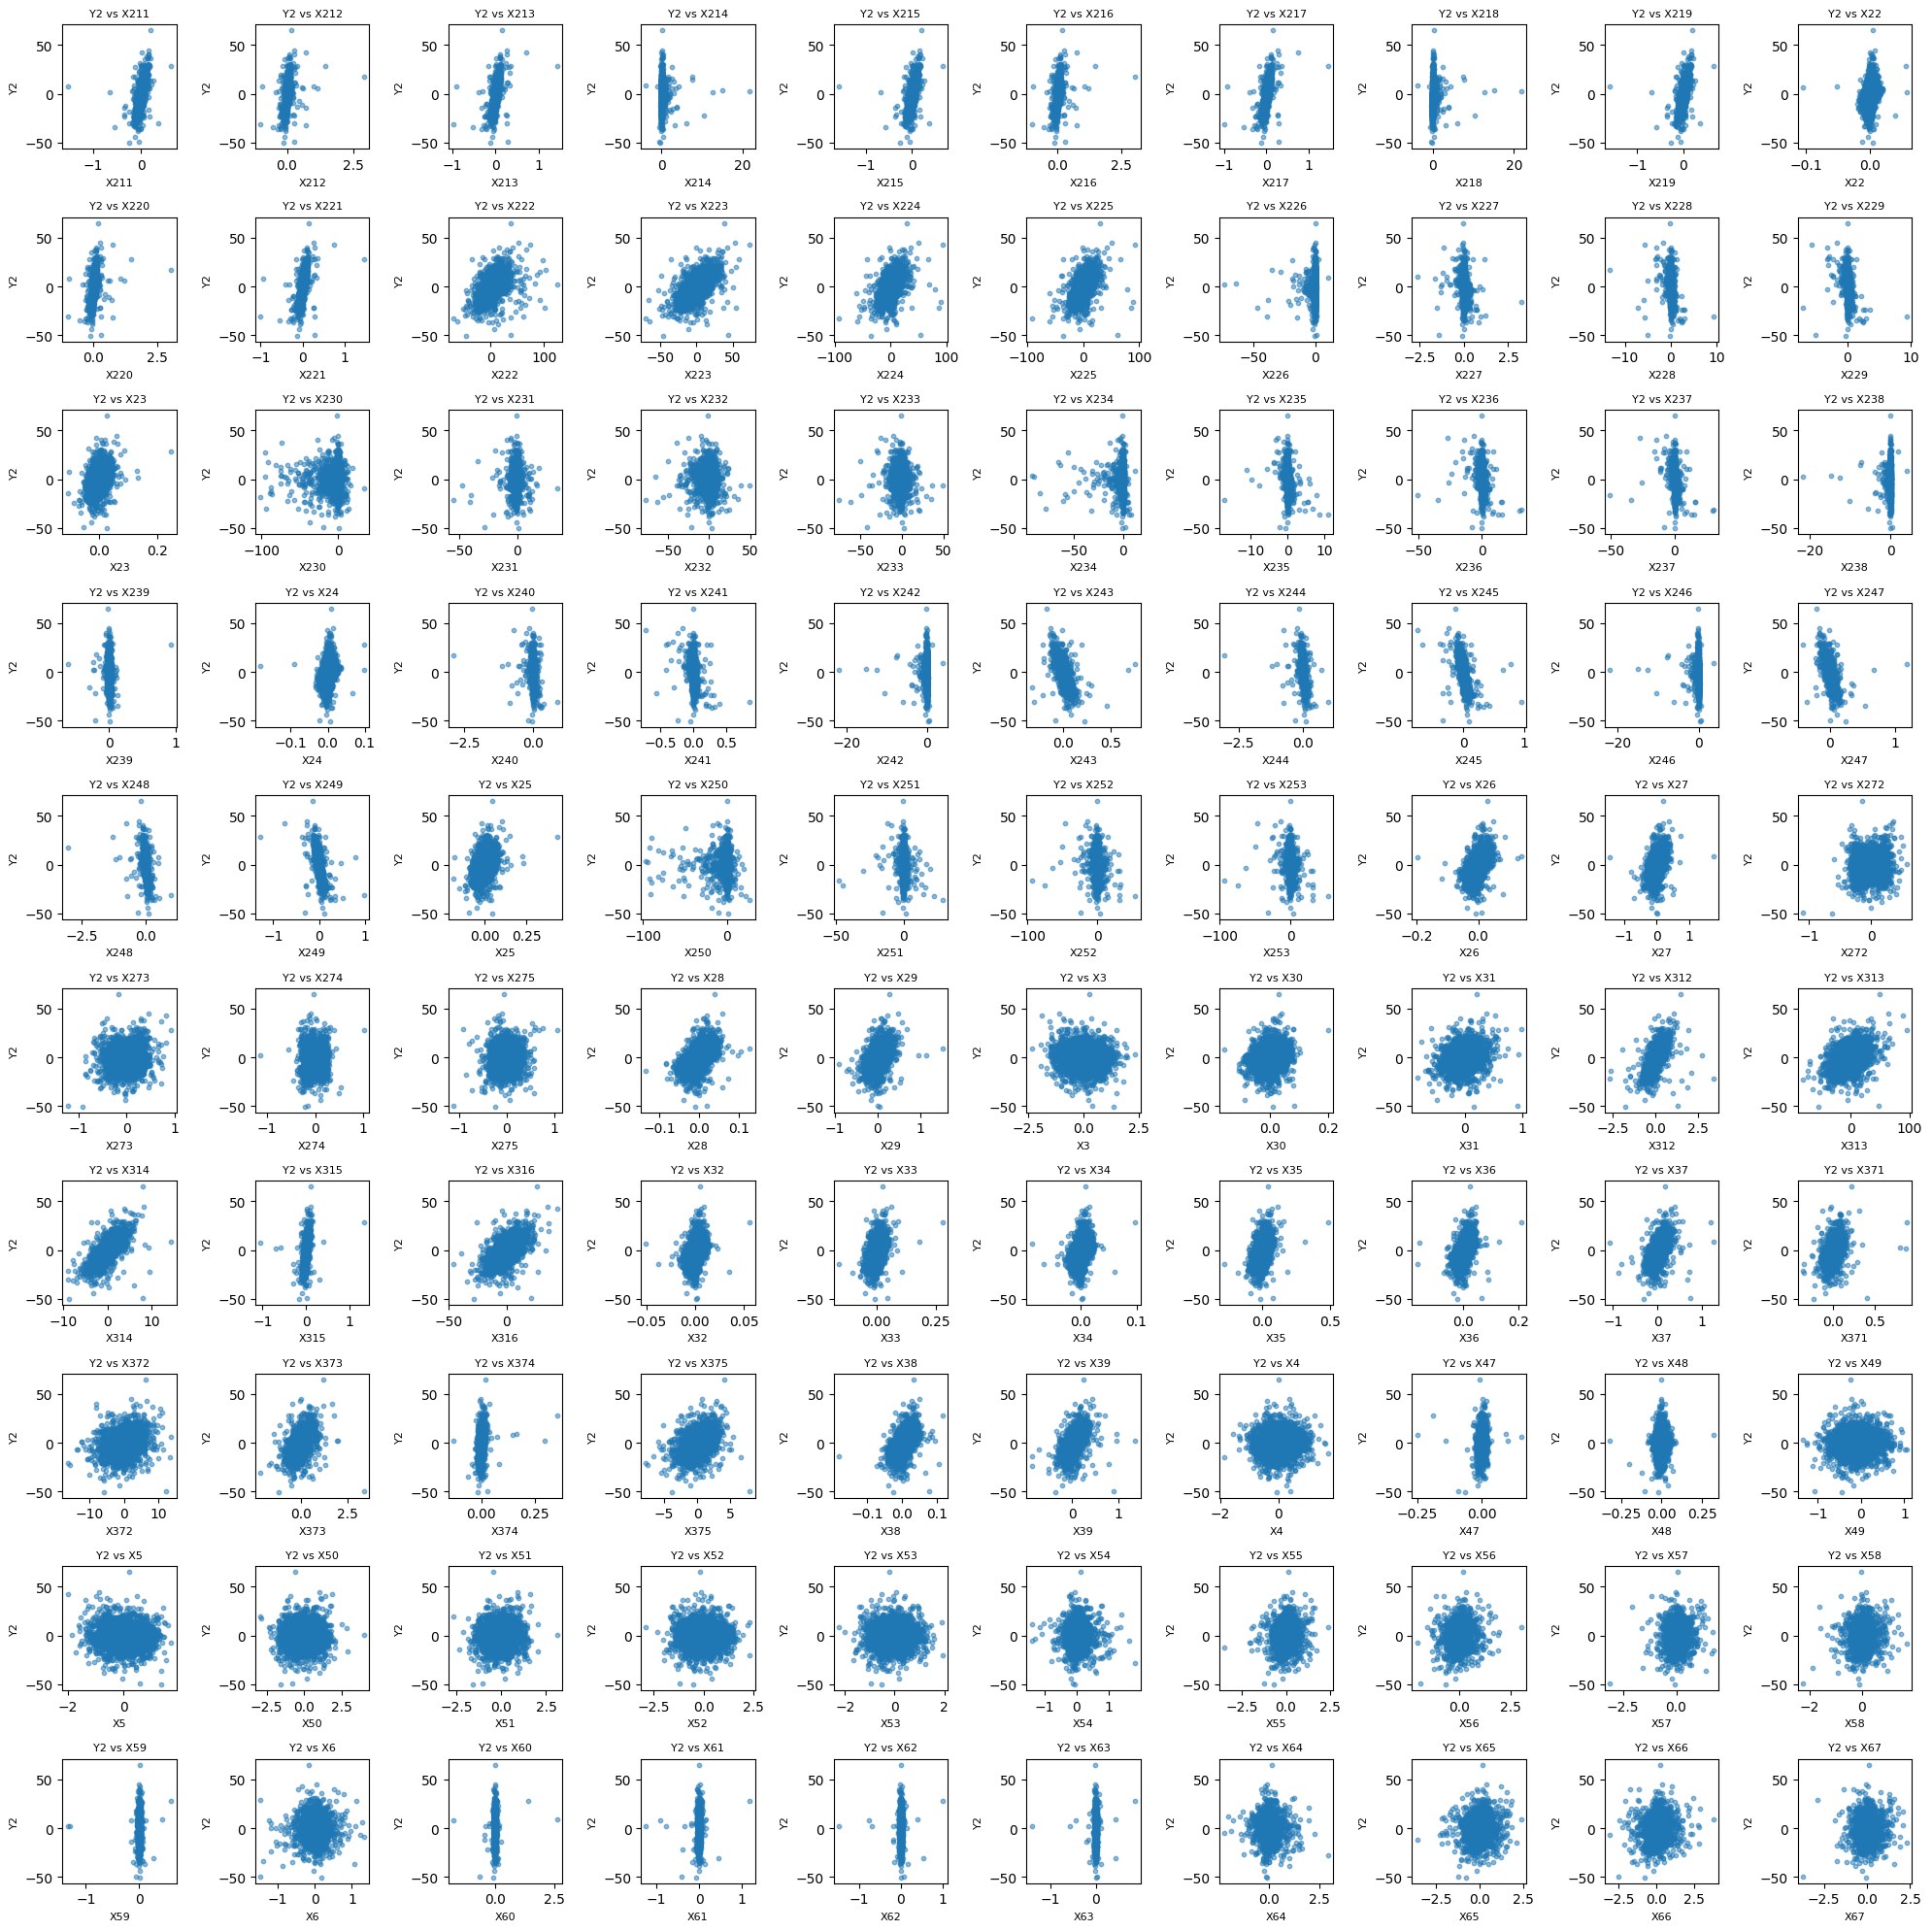

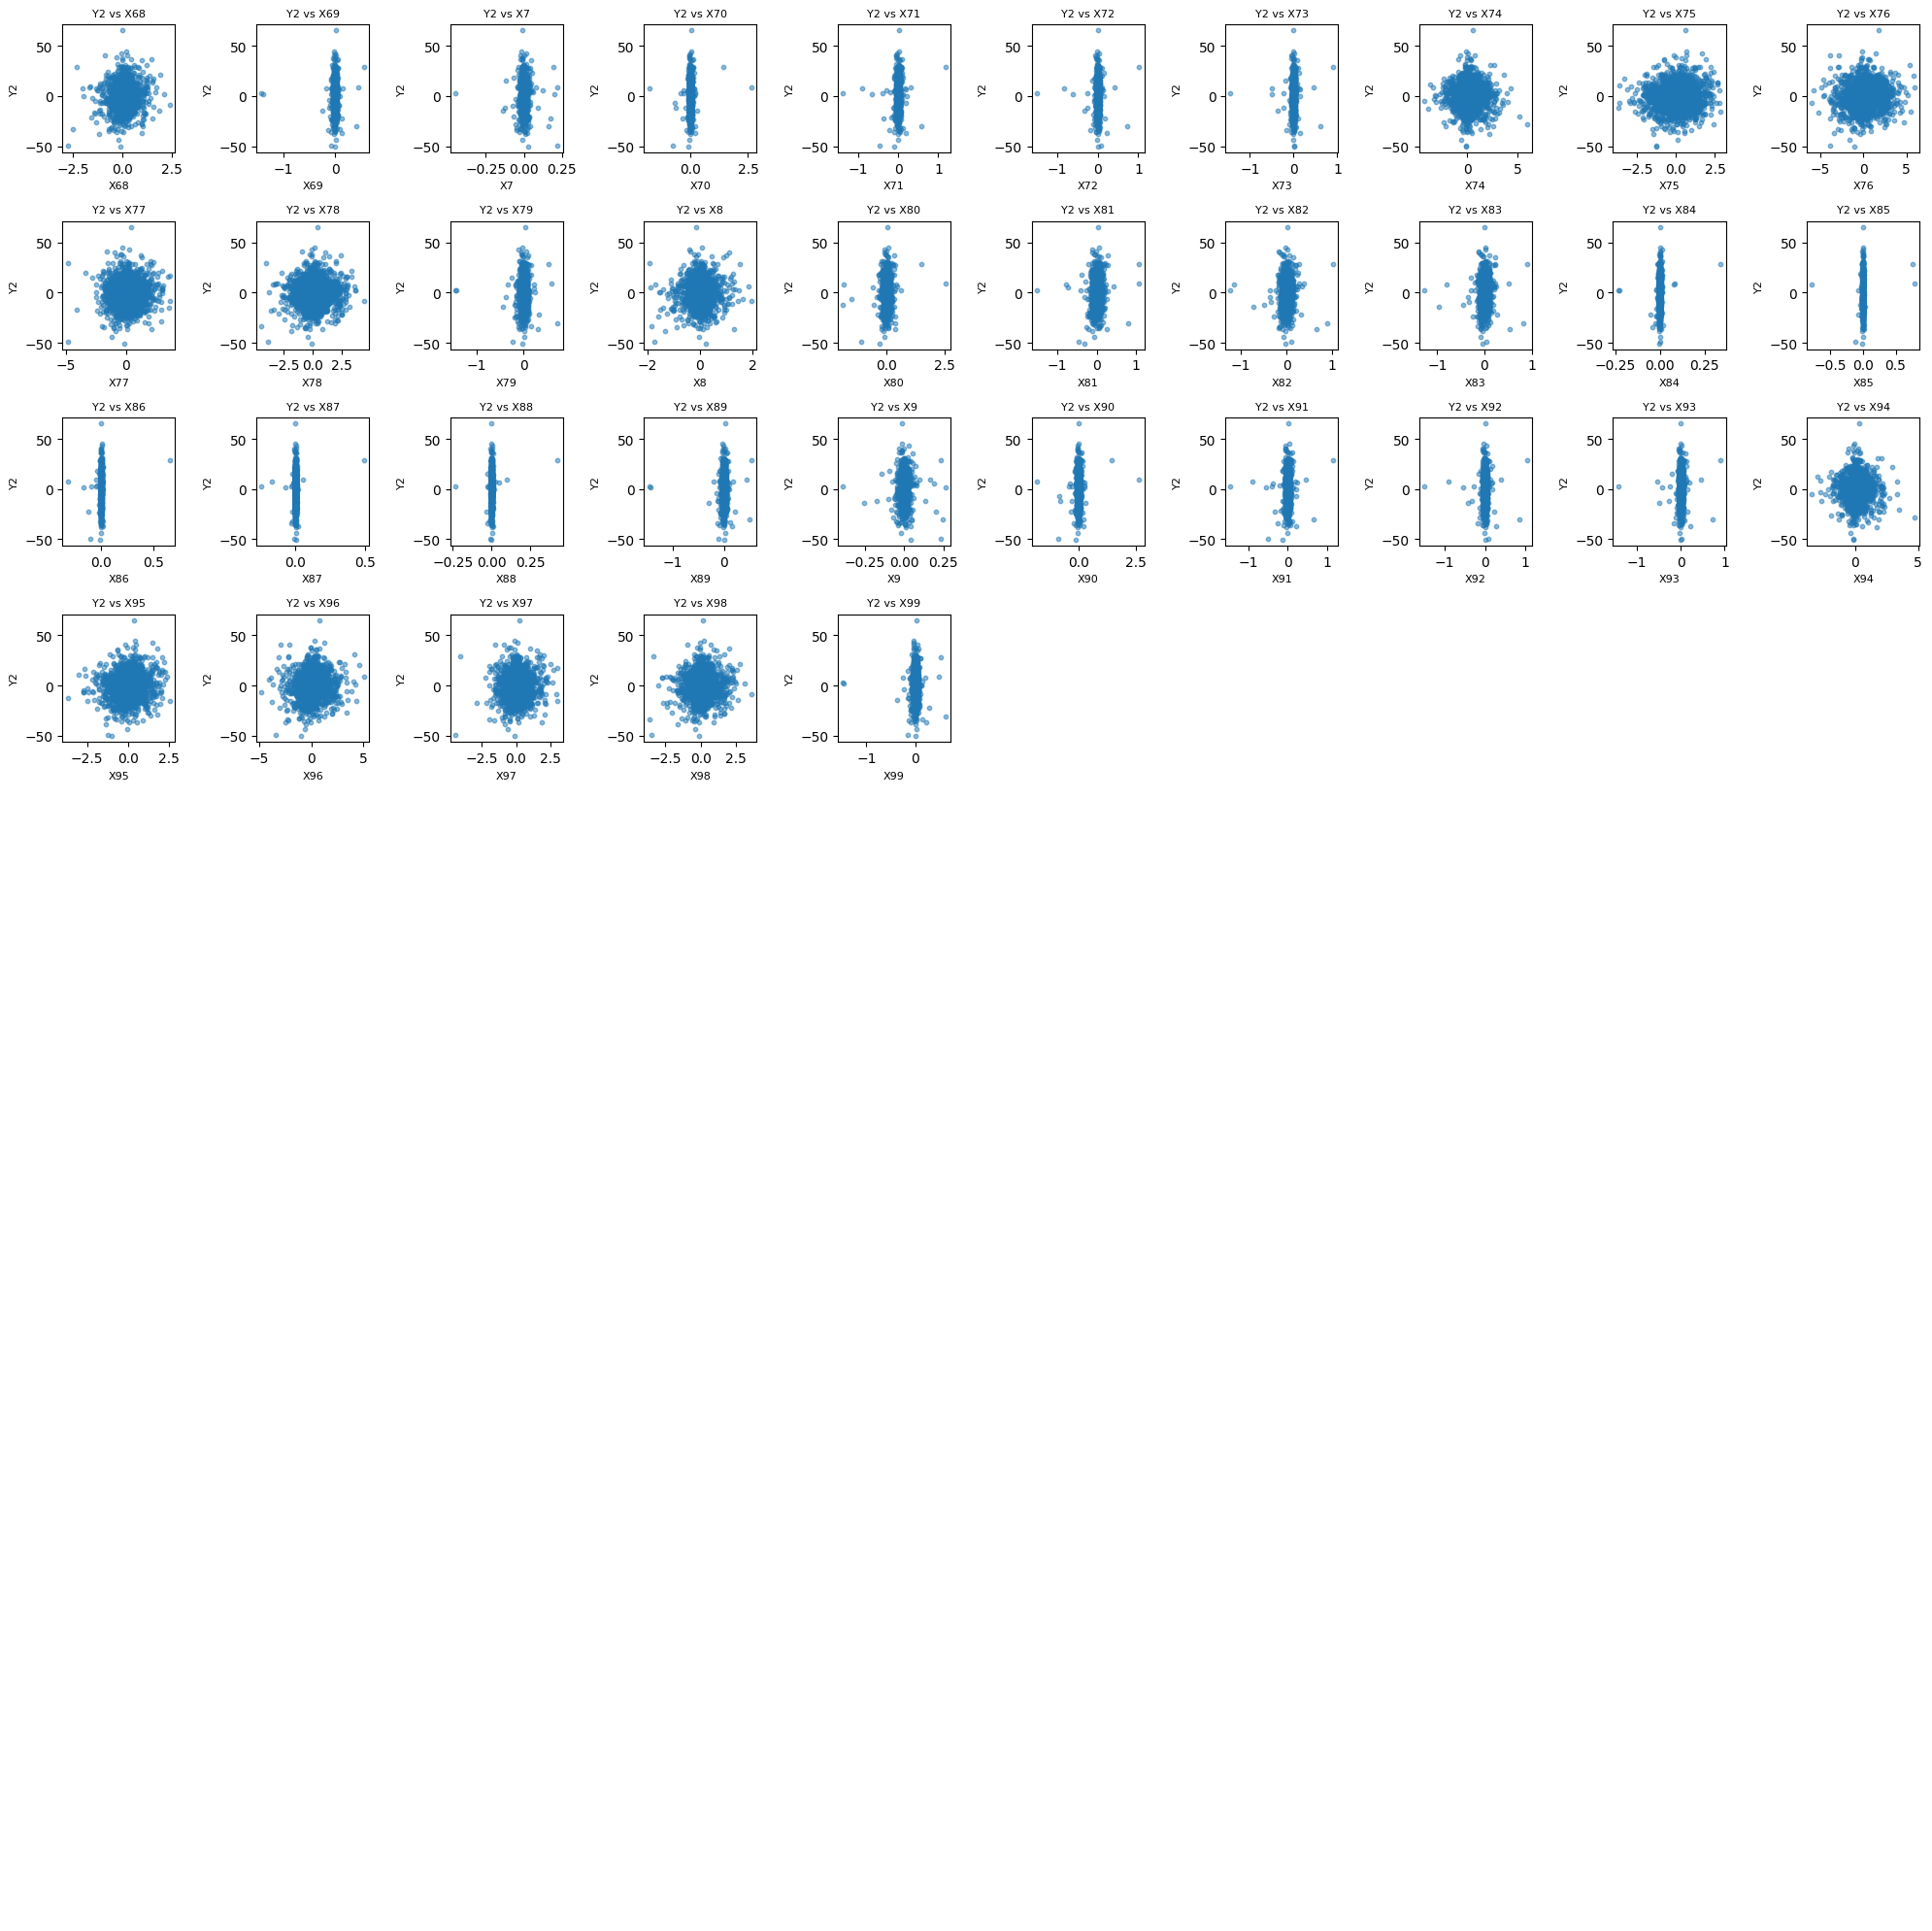

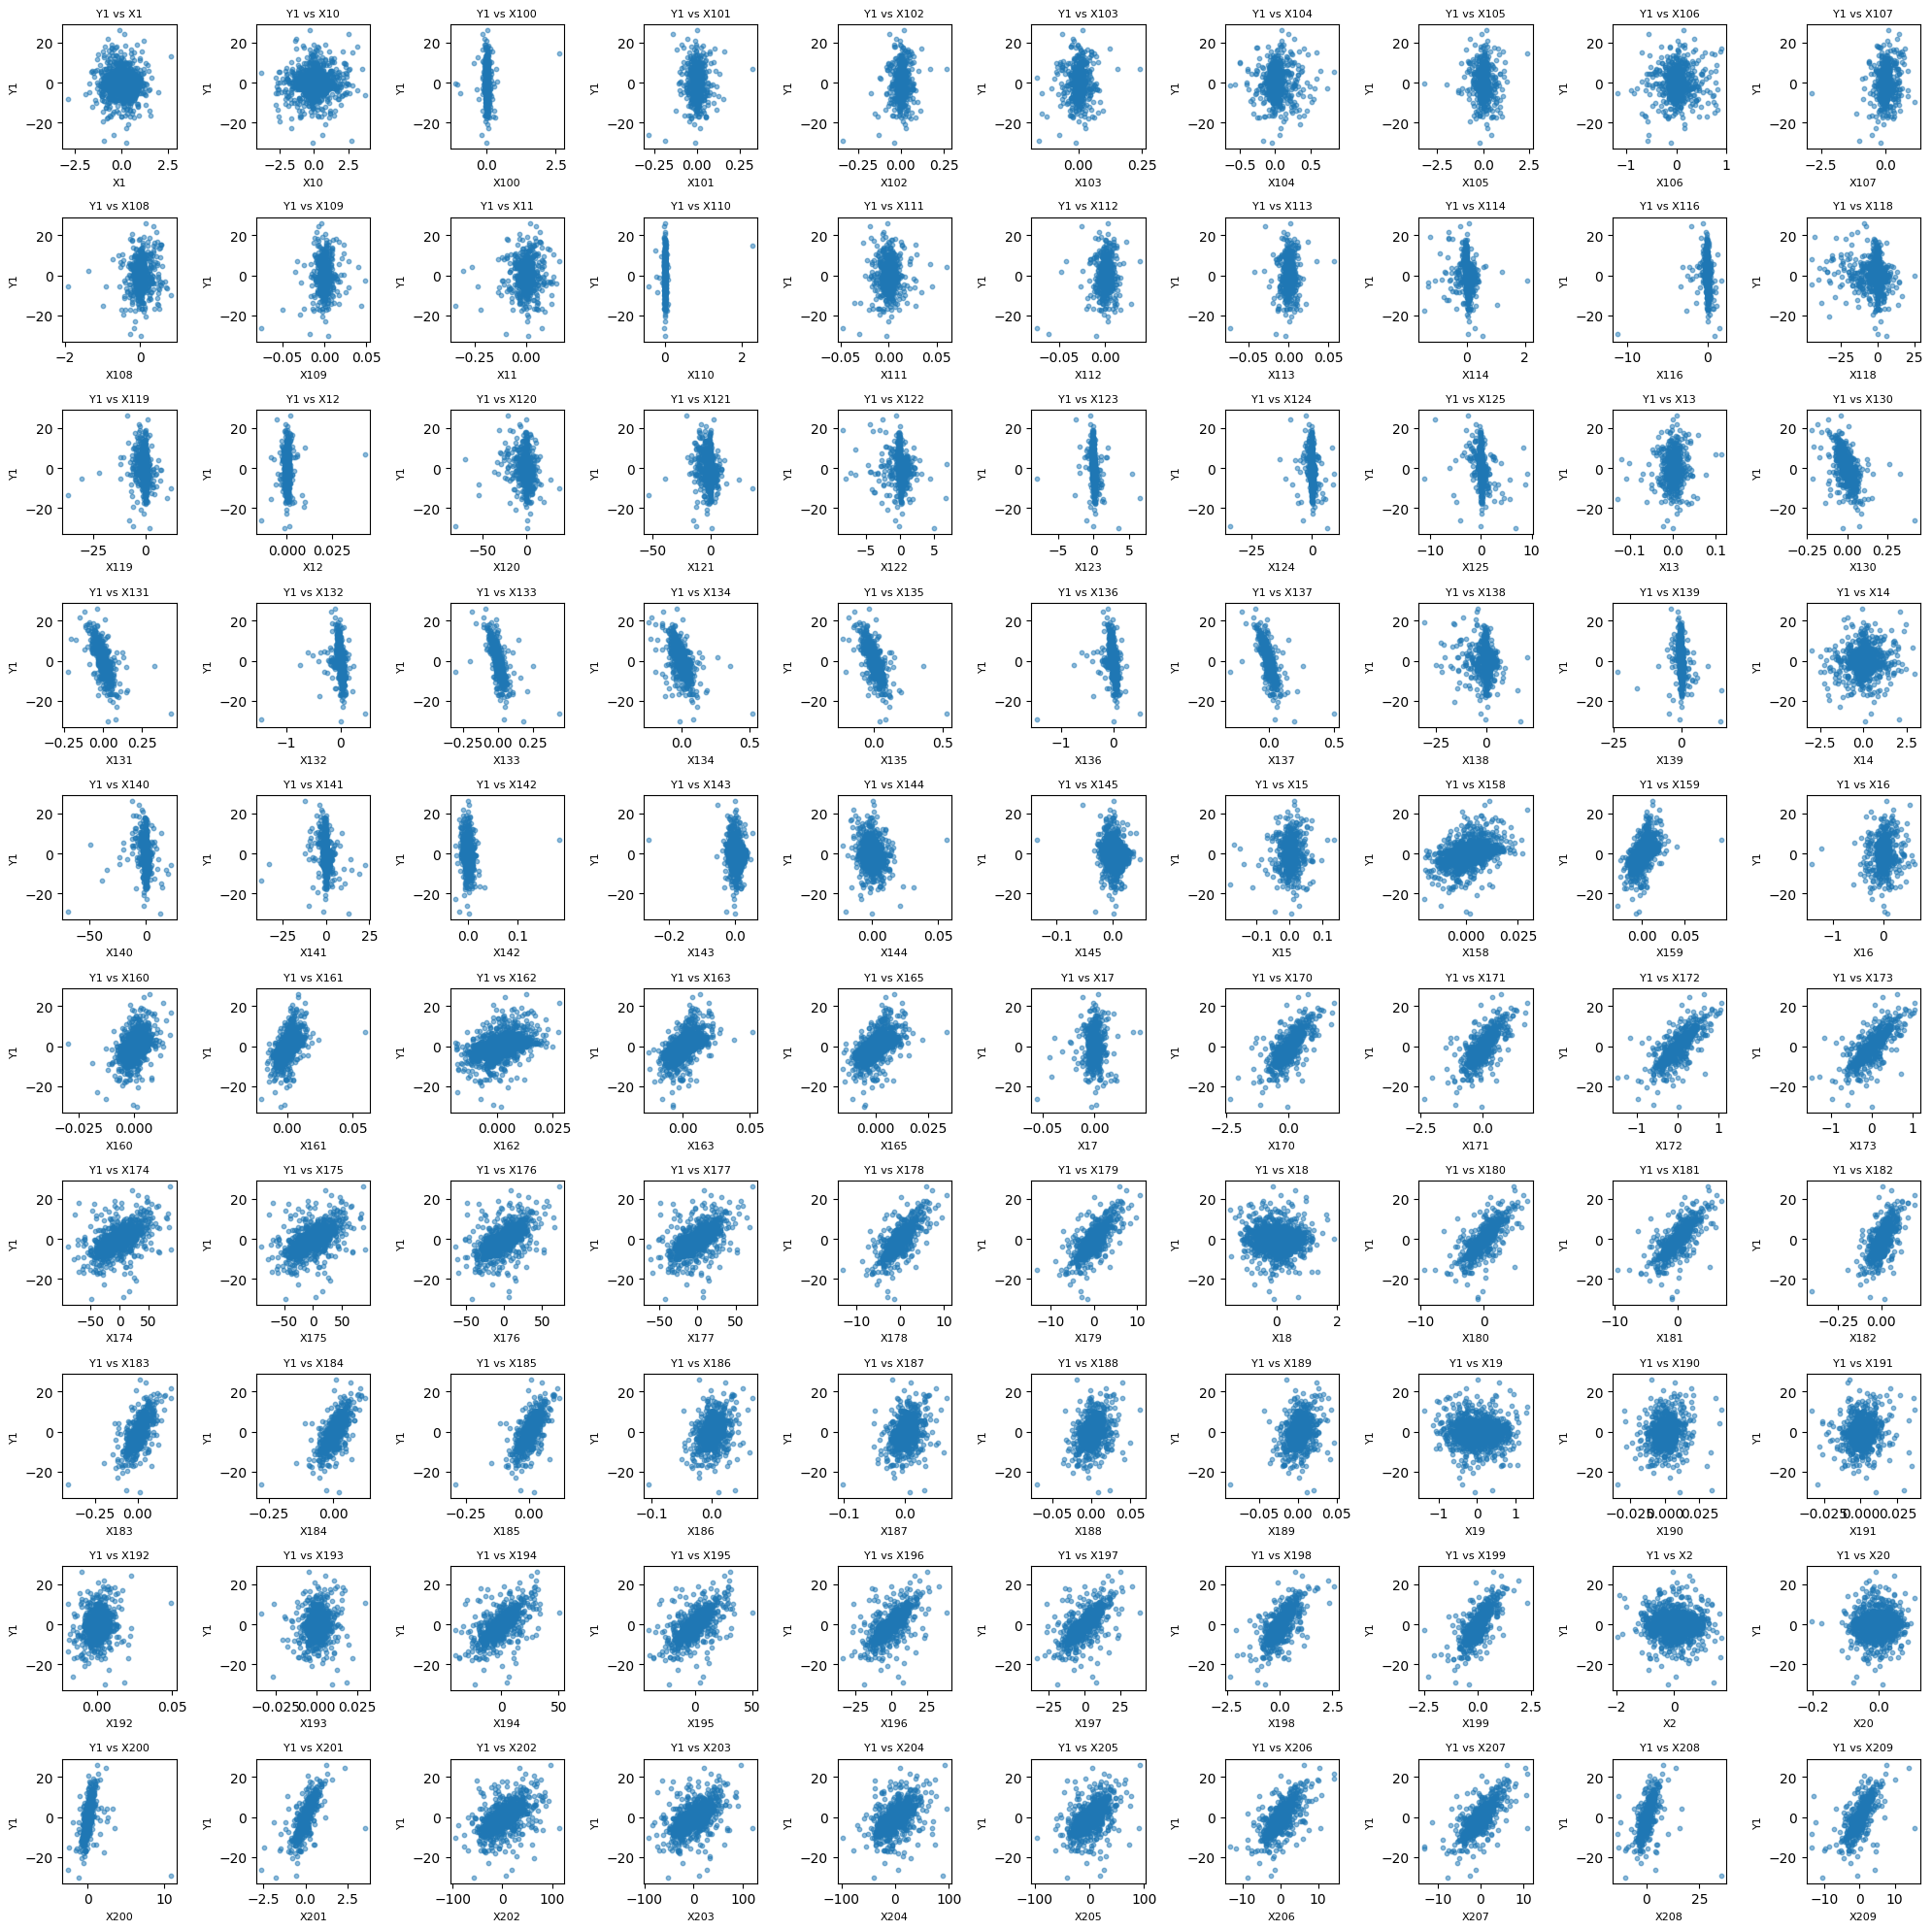

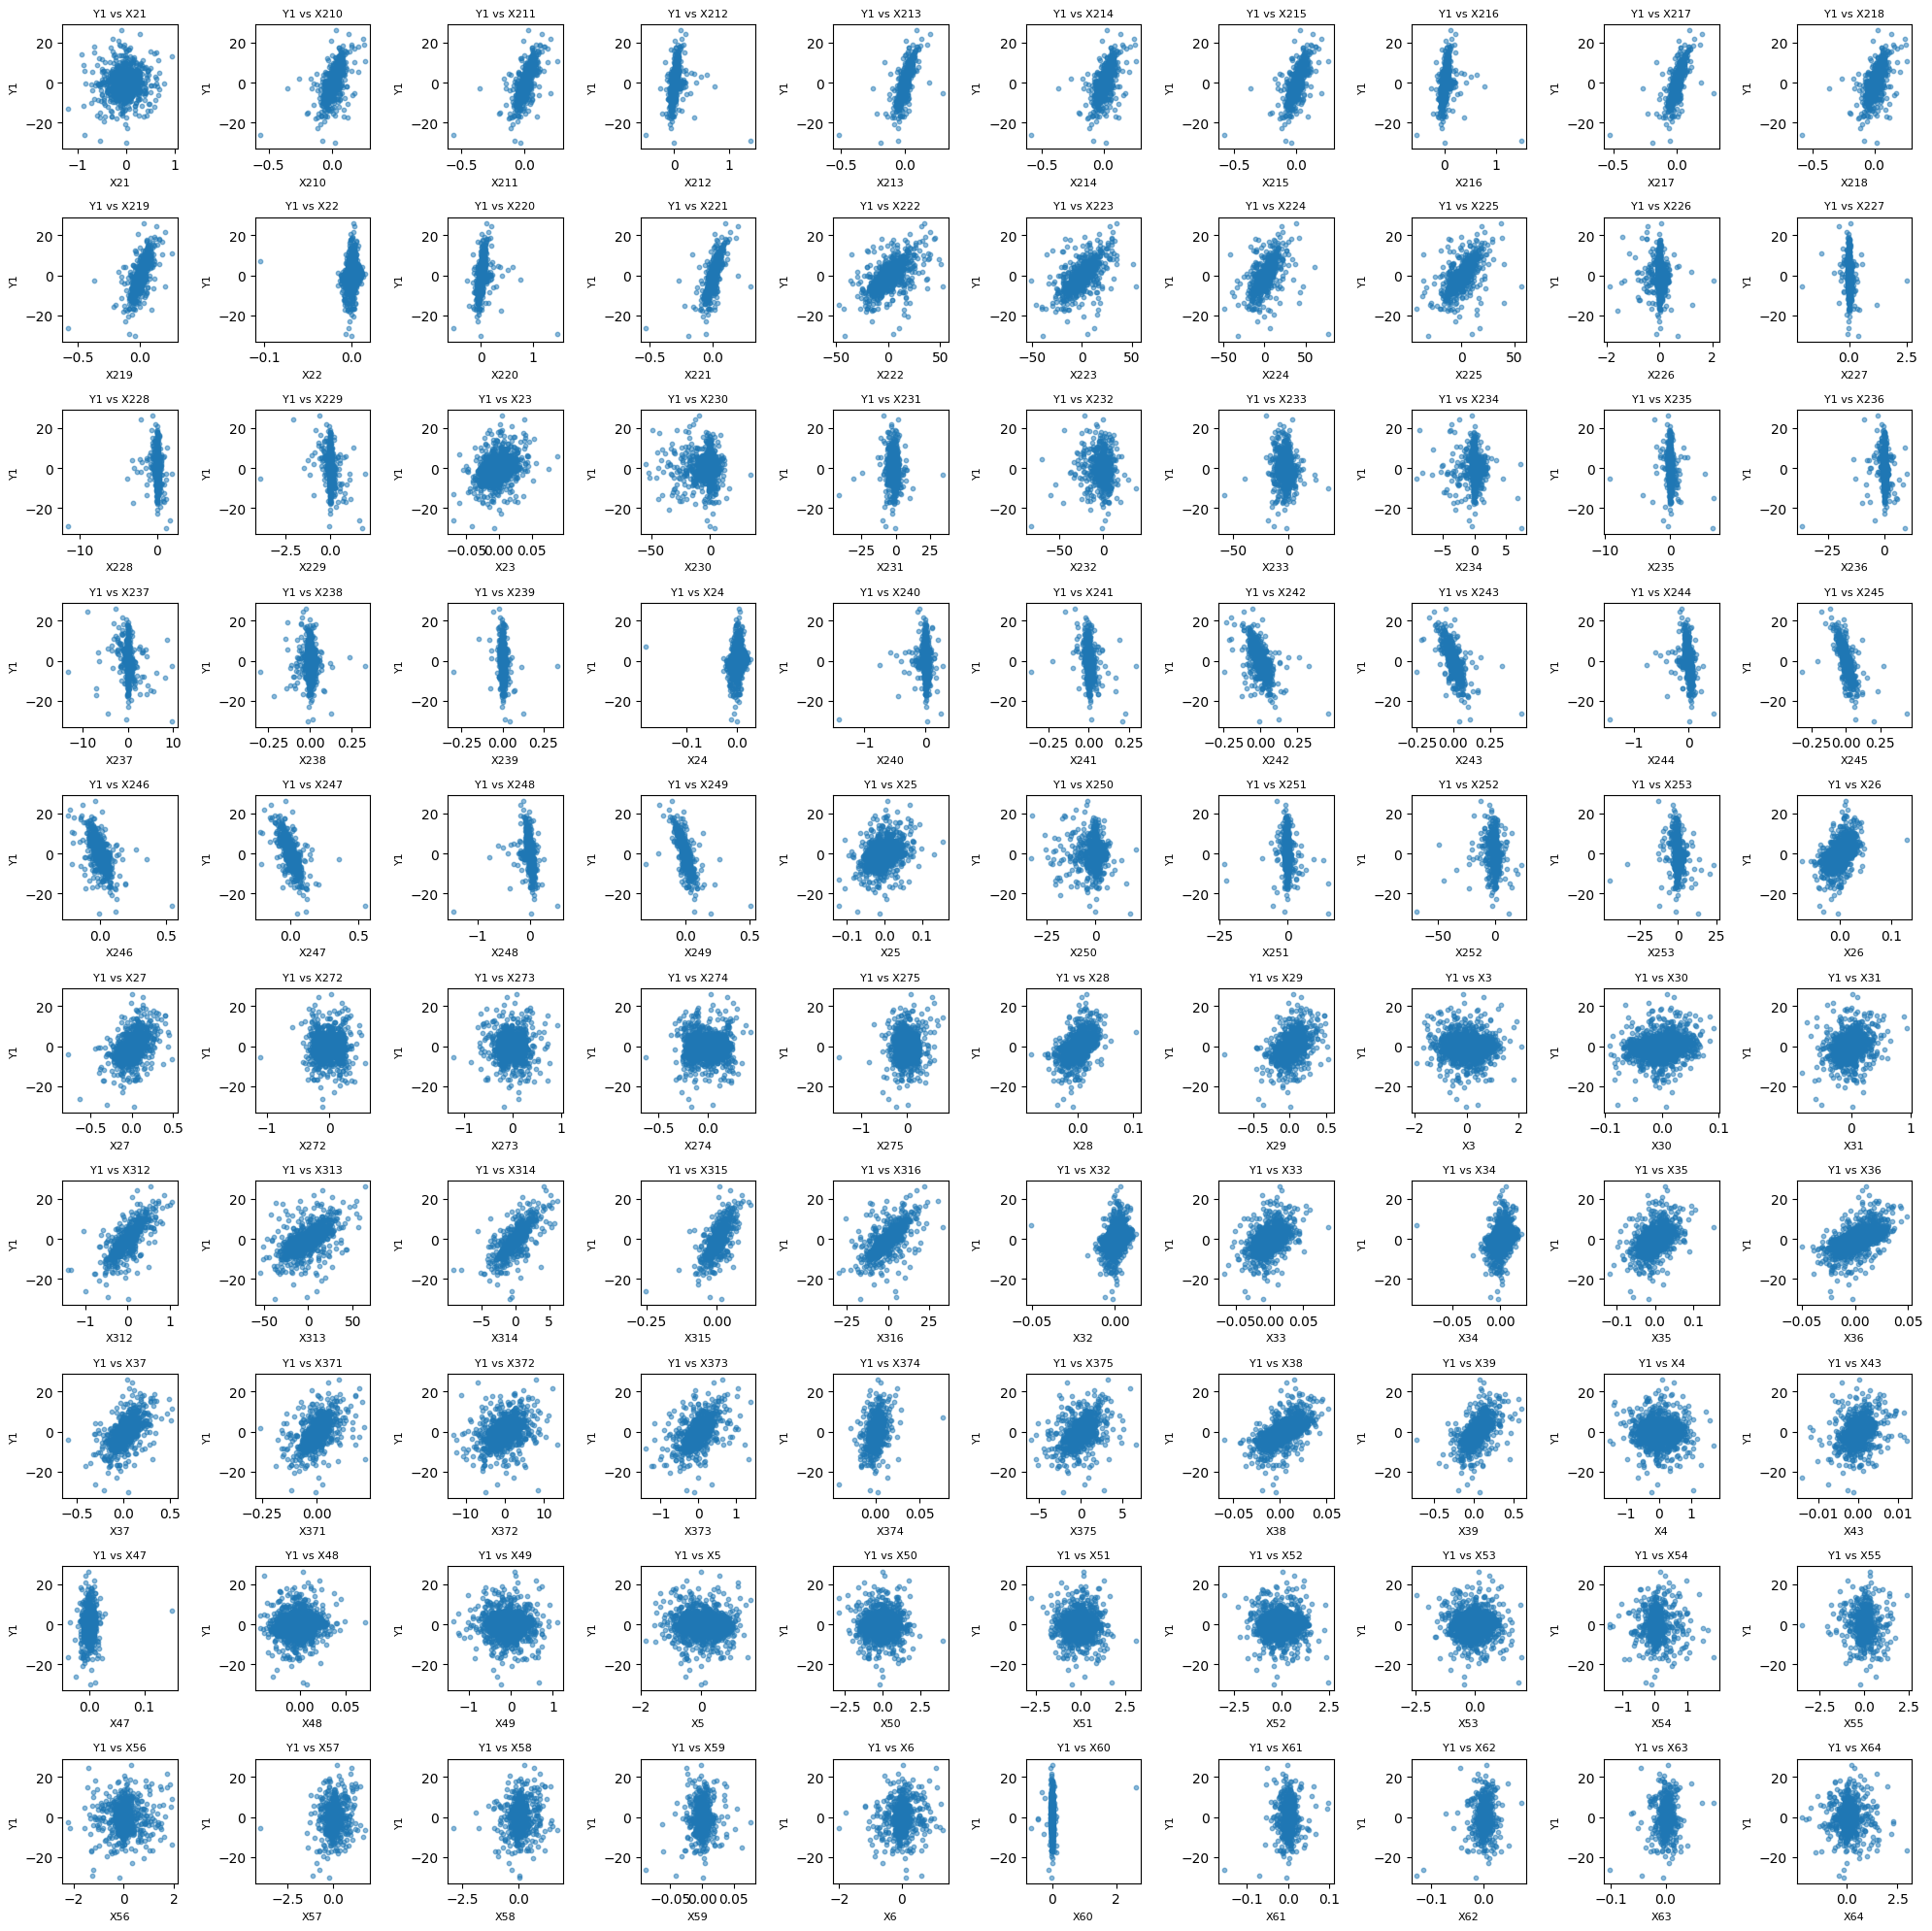

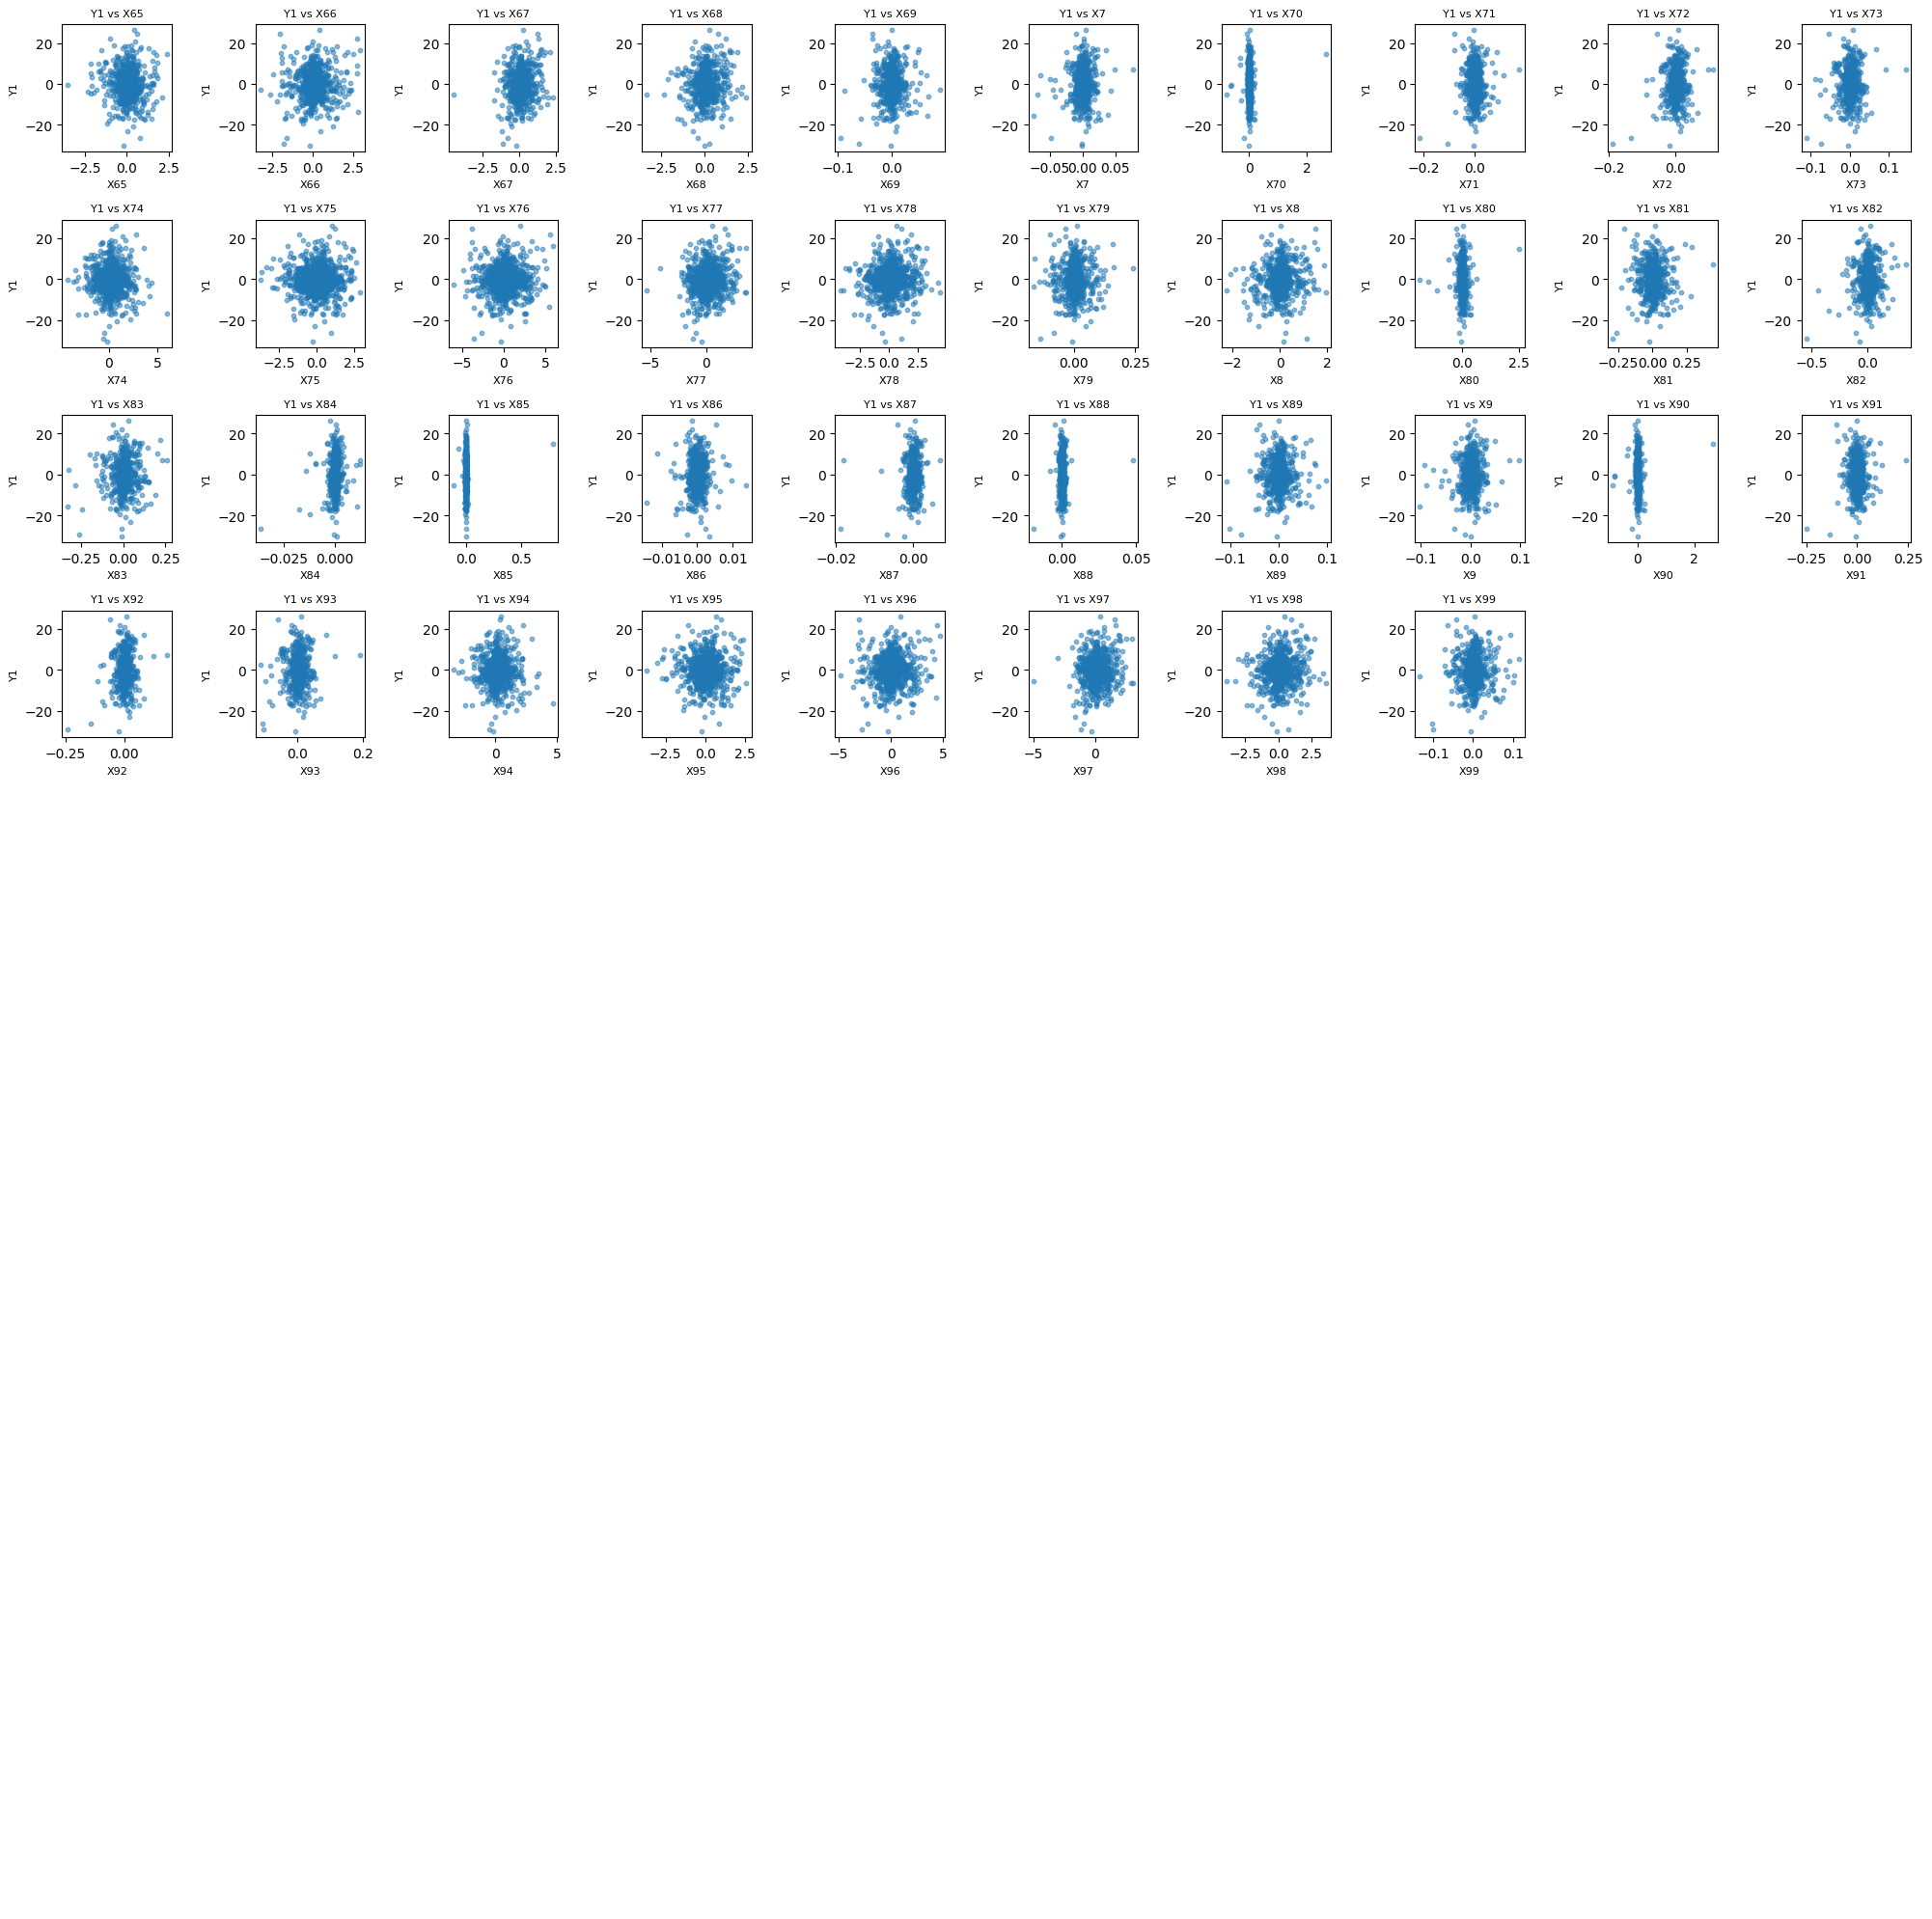

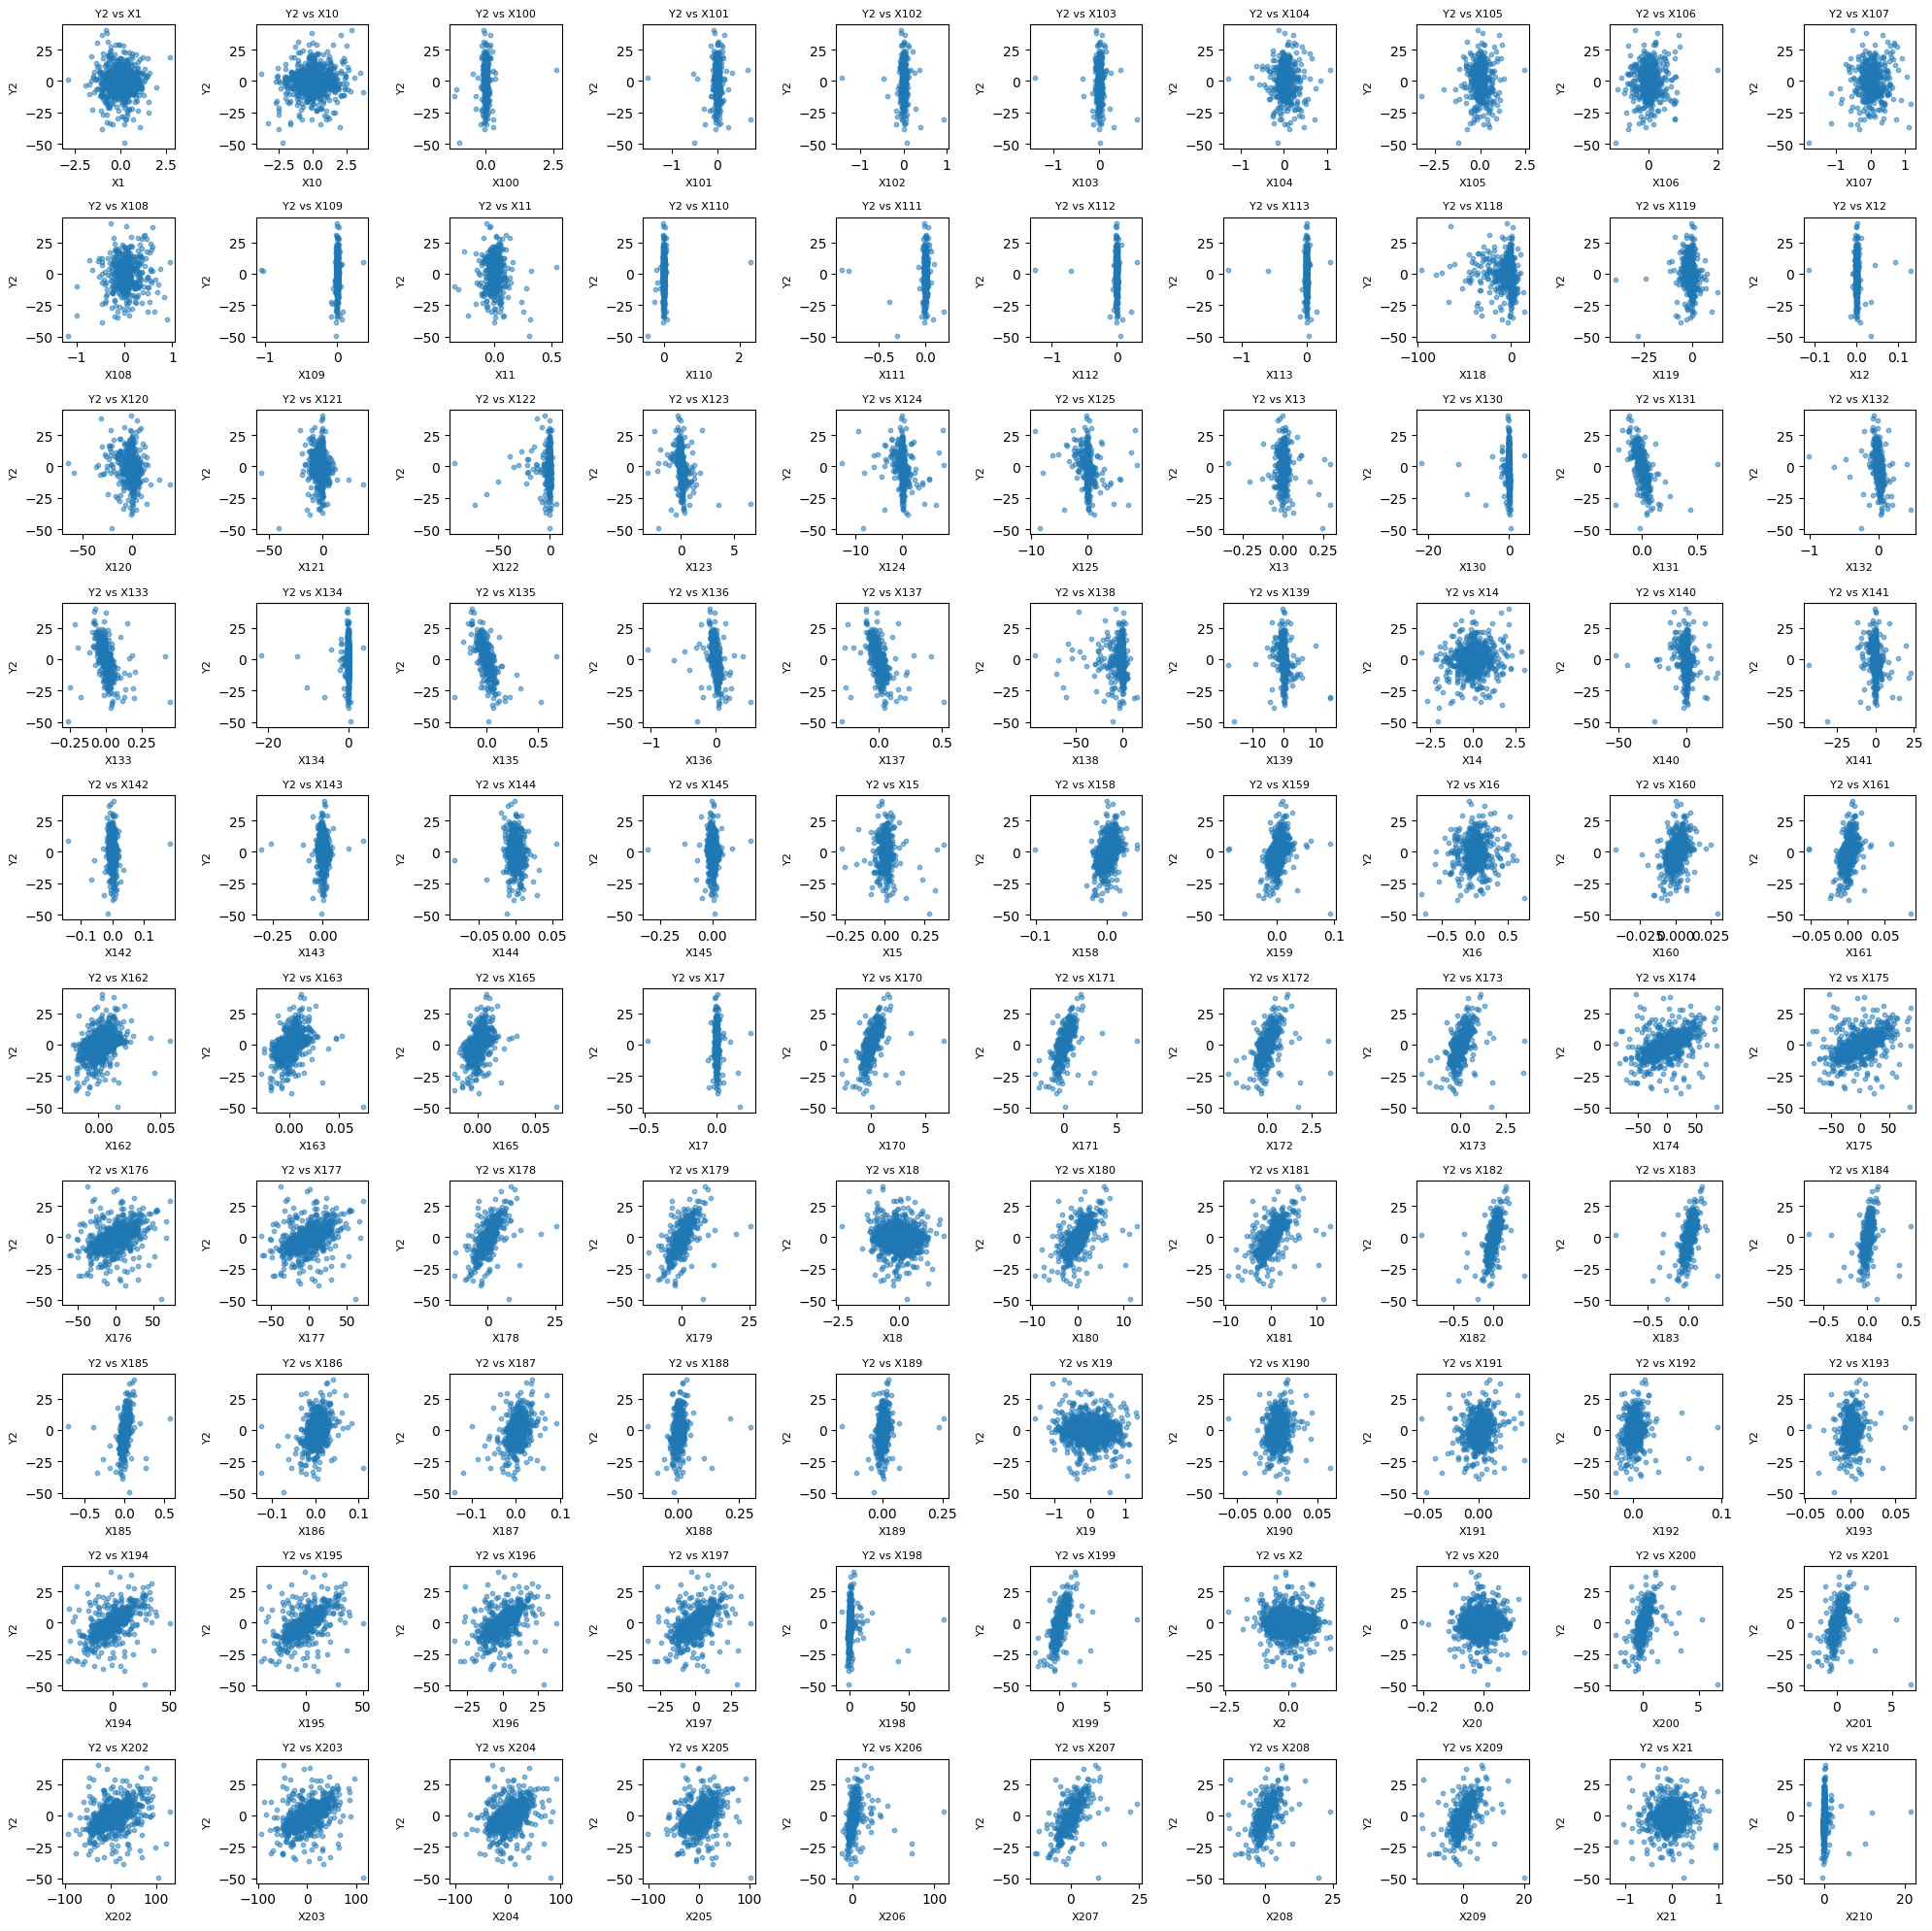

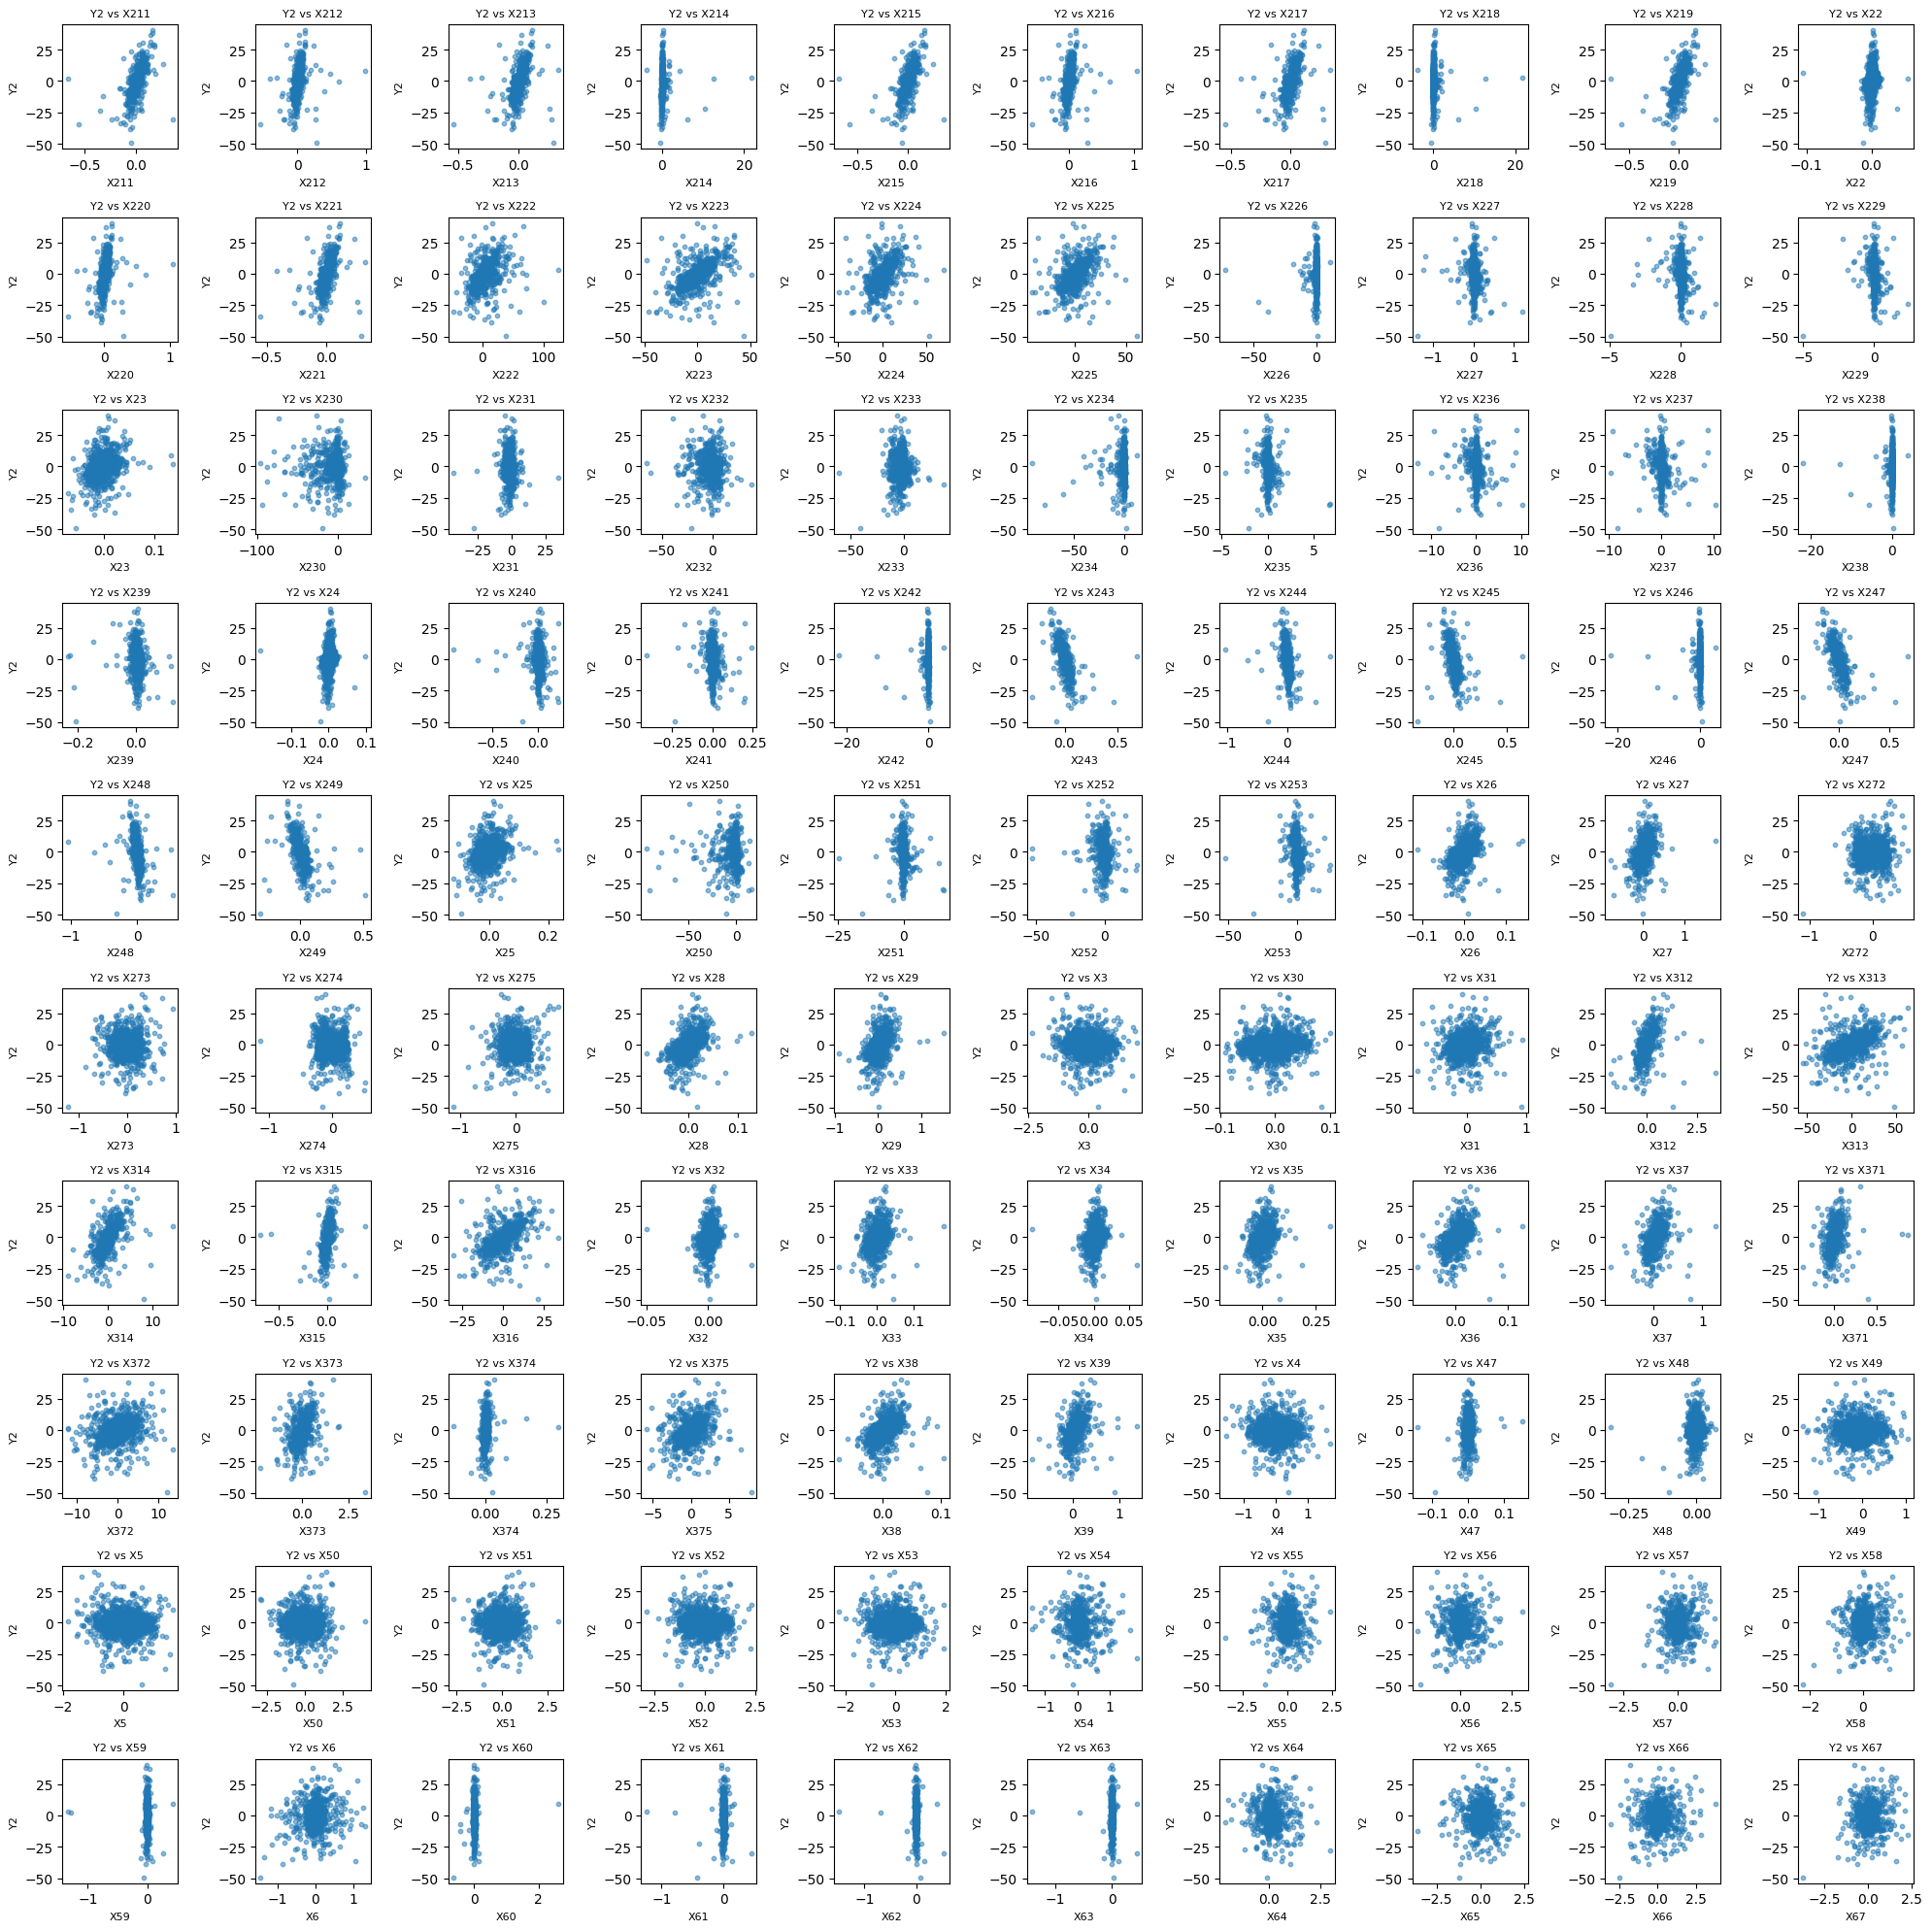

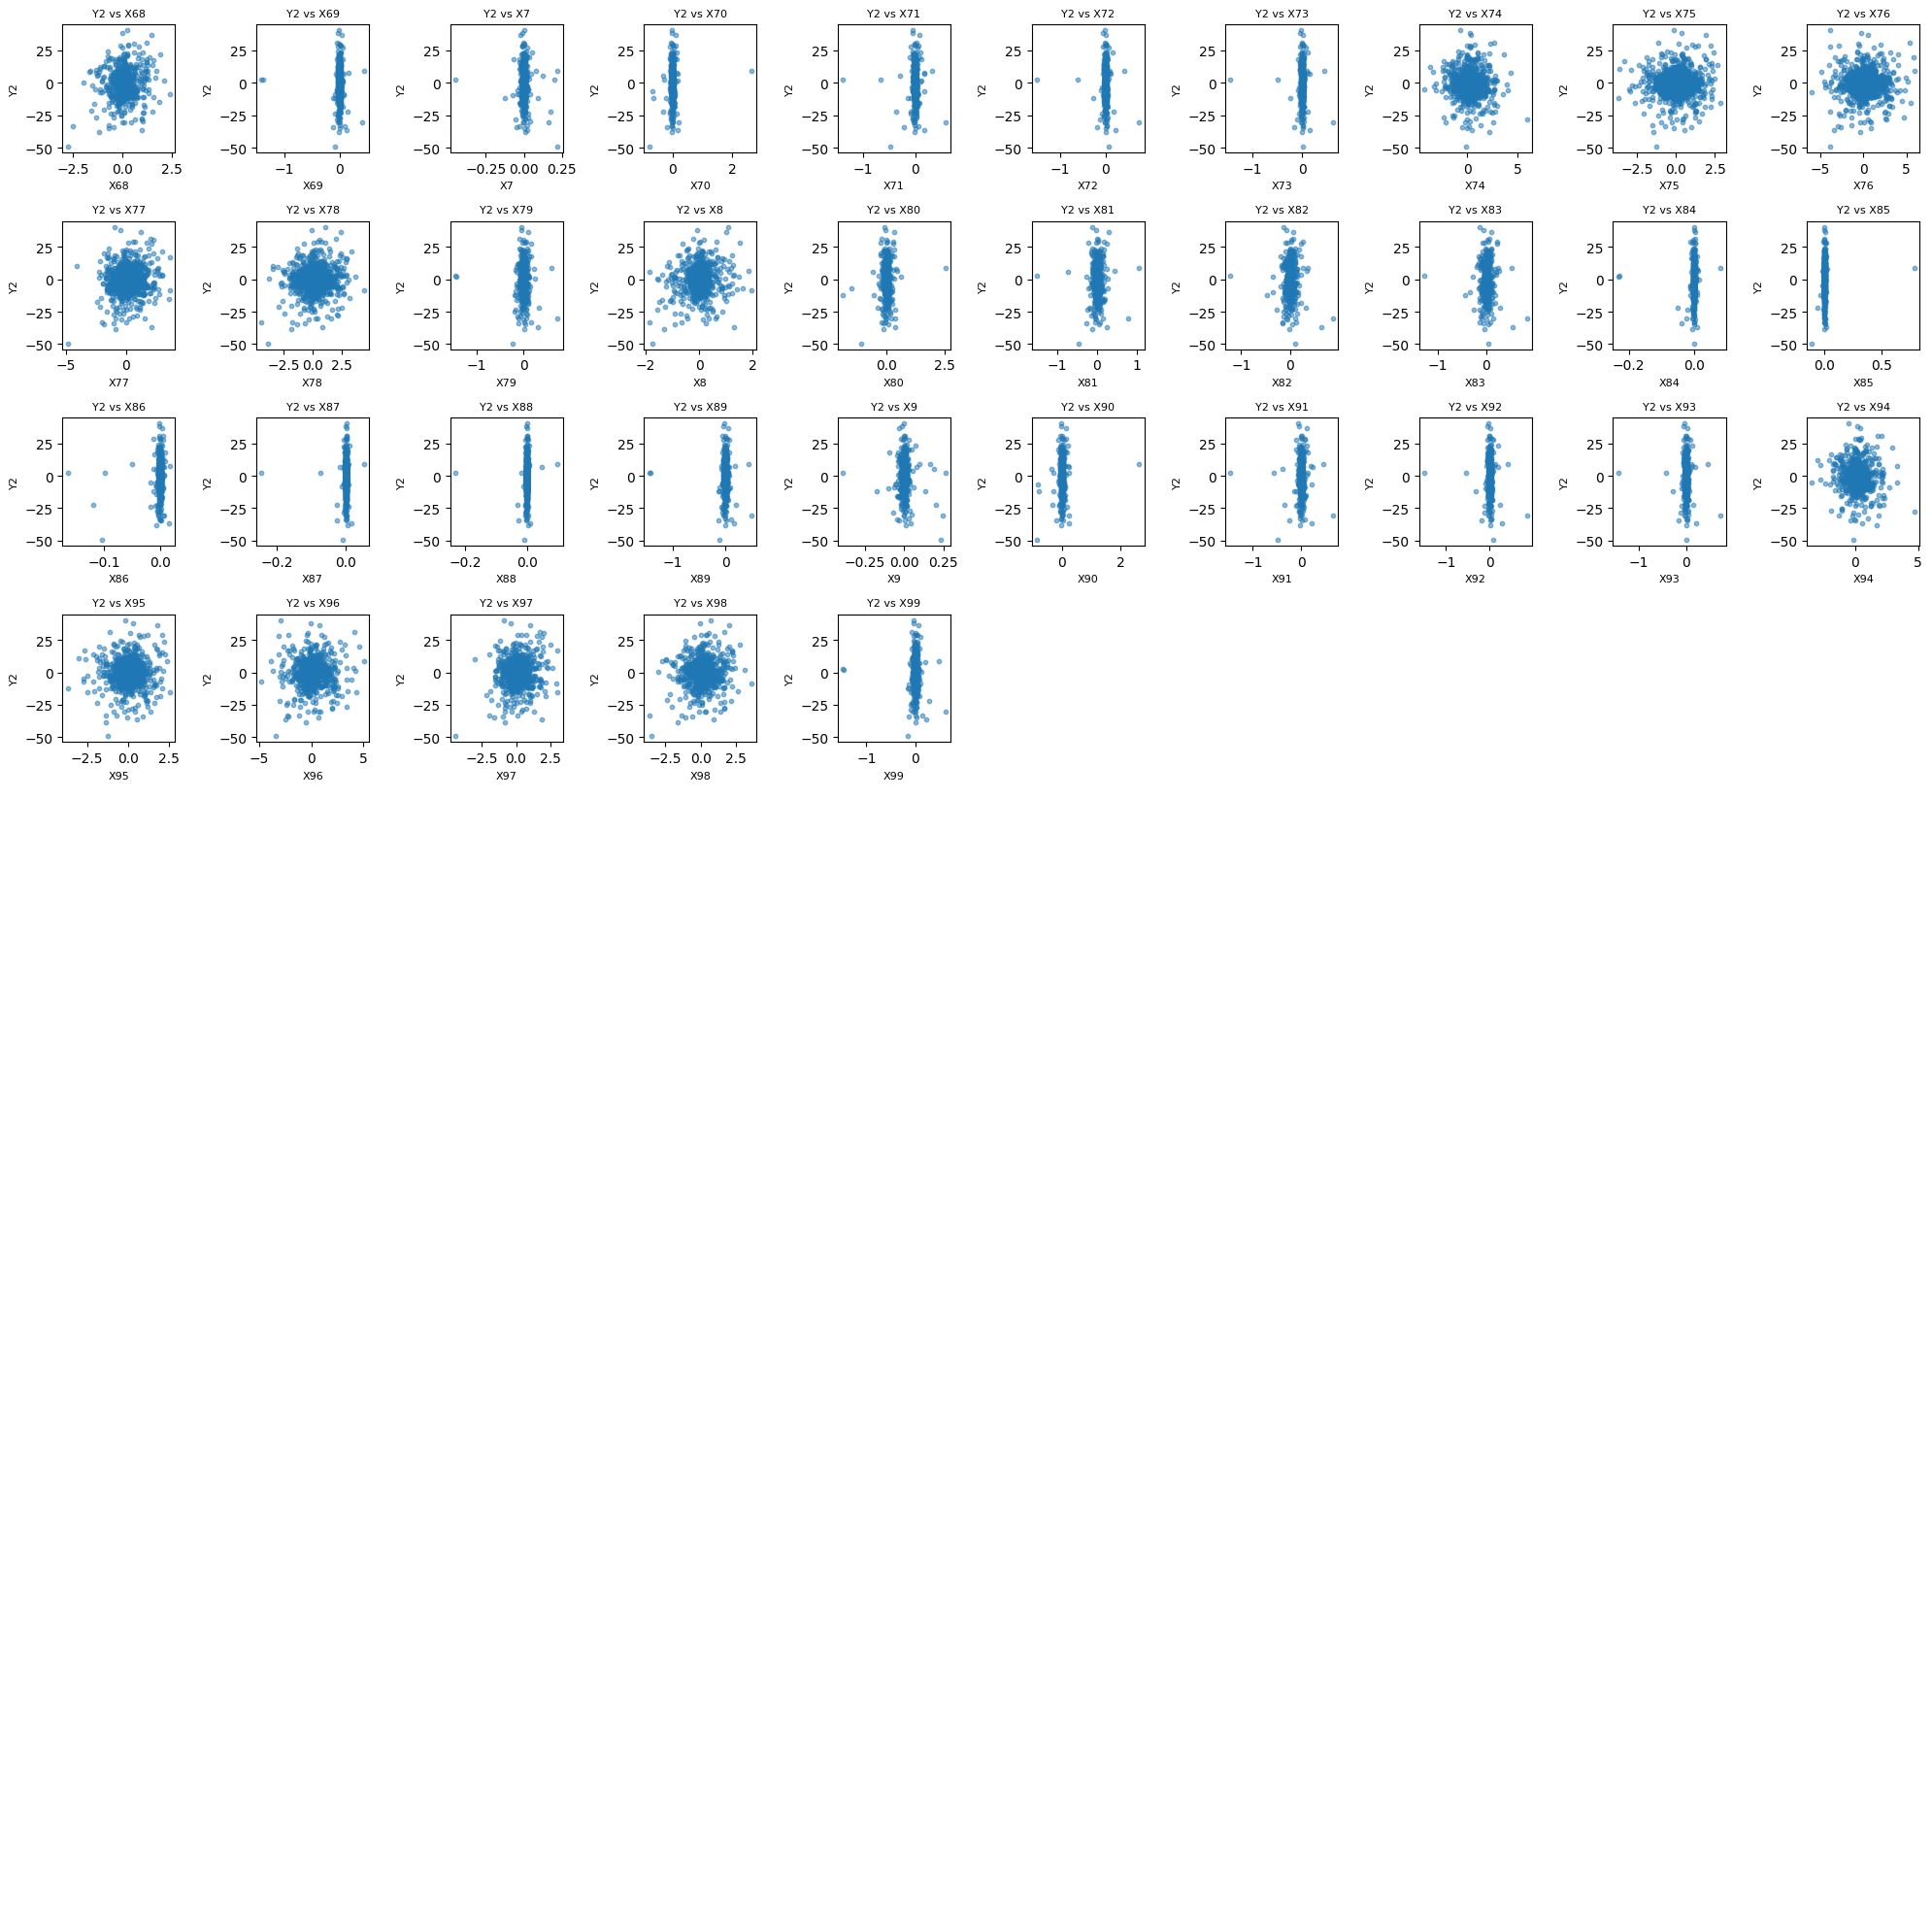

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_and_save(data_path, output_base):
    # Load data
    data = pd.read_pickle(data_path)

    # Extract column names starting with 'X' from the DataFrame
    parameters = [col for col in data.columns if col.startswith('X')]

    # Determine which Y variable to use based on the file name
    if 'Q1' in data_path:
        y_variable = 'Y1'
    elif 'Q2' in data_path:
        y_variable = 'Y2'
    else:
        raise ValueError("Unable to determine the Y variable from the file name.")

    # Calculate the number of 10x10 plots needed to display all parameters
    num_parameters = len(parameters)
    plots_needed = int(np.ceil(num_parameters / 100.0))
    grid_size = 10

    # Iterate through each set of 100 parameters to create 10x10 subplots
    for plot_number in range(plots_needed):
        # Determine the parameters for this particular grid
        start_idx = plot_number * 100
        end_idx = min(start_idx + 100, num_parameters)
        parameters_subset = parameters[start_idx:end_idx]

        # Create the subplot grid
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))
        axes = axes.flatten()

        # Iterate over each parameter in the subset and create a scatter plot
        for i, column in enumerate(parameters_subset):
            ax = axes[i]
            ax.scatter(data[column], data[y_variable], alpha=0.5, s=10)
            ax.set_title(f'{y_variable} vs {column}', fontsize=8)
            ax.set_xlabel(column, fontsize=8)
            ax.set_ylabel(y_variable, fontsize=8)

        # Turn off any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        # Save the plot before showing it
        plt.savefig(f'{output_base}_plot_{plot_number + 1}.png')

        plt.show()

plot_and_save('Datasave/Q1_resample_20min_0.6.pkl', 'Plot n result save/Q1_20min_0.6')
plot_and_save('Datasave/Q2_resample_20min_0.6.pkl', 'Plot n result save/Q2_20min_0.6')
plot_and_save('Datasave/Q1_resample_1H_0.6.pkl', 'Plot n result save/Q1_1H_0.6')
plot_and_save('Datasave/Q2_resample_1H_0.6.pkl', 'Plot n result save/Q2_1H_0.6')
